# ***Libraries***

In [1]:
import math
import os
import sys
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from CUSUM import CUSUM

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
sys.path.append(parent_dir)

In [4]:
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length, plotFig, printResult

from TSB_UAD.models.iforest import IForest

# ***Non-Streaming Methods***
We pick non-streaming methods of our choice as a baseline. We experiment on the randomly generated files of the dictionary. In the non-streaming setting we use the entire generated files as input. We later modify the methods to operate in a streaming setting.


## ***Data Pre-Processing***

In [5]:
# Load the Time-Series dictionary
with open('Time-Series_Data_Dictionaries/Time-Series-Random-Data-of-Interest-Dictionary.json', 'r') as json_file:
    loaded_dict = json.load(json_file)

Let's see some info about the generated files

In [6]:
for filename, info in loaded_dict.items():
    print(f'{filename}: {info}')

ts1: ['Normality_1', 'SensorScope']
ts3: ['Normality_1', 'NASA-MSL']
ts4: ['Normality_1', 'YAHOO']
ts5: ['Normality_1', 'SMD']
ts8: ['Normality_1', 'SMD']
ts2: ['Normality_2', 'SensorScope', 'NAB']
ts9: ['Normality_2', 'Occupancy', 'NASA-MSL']
ts6: ['Normality_3', 'SensorScope', 'YAHOO', 'NASA-MSL']
ts7: ['Normality_3', 'YAHOO', 'NASA-MSL', 'SMD']


In [87]:
preprocessed_dict = {}

### ***Pre-processing for non-streaming methods***
Simple data pre-processing based on TSB-UAD. This pre-processing serves as the pre-processing baseline

In [9]:
for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised methods
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1]

    slidingWindow = find_length(data)
    X_data = Window(window=slidingWindow).convert(data).to_numpy()

    # Prepare data for semisupervised methods
    # The training ratio = 0.1

    """
    data_train = data[:int(0.1 * len(data))]
    data_test = data

    X_train = Window(window=slidingWindow).convert(data_train).to_numpy()
    X_test = Window(window=slidingWindow).convert(data_test).to_numpy()

    print(f'Time-Series filename: {filename}')
    print("Estimated Subsequence length: ", slidingWindow)
    print()
    """
    
    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'label': label,
        'slidingWindow': slidingWindow,
        'X_data': X_data,
        #'data_train': data_train,
        #'data_test': data_test,
        #'X_train': X_train,
        #'X_test': X_test,
        'Time series length': len(data),
        'Number of abnormal points': list(label).count(1)
    }

### ***Pre-processing for naive streaming variants of non-streaming methods***
In a streaming setting we are unaware of the data size. Thus, we have to define batches/artitions of some points. In this simple naive variant, we assume we know the data size in order to properly define the number of points each partition will have. In other words, we naively say that each batch/partition will be have a specifc number of points.

In [9]:
n = 5 # Number of partitions

In [9]:
for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised methods
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1]
    global_sw = find_length(data) # The sliding window calculated for all data

    data_partitions = []
    sliding_windows = []
    x_data_partitions = []

    # Divide data based on n and add the remaining points to the last partition
    partition_size = int(math.floor(len(data) / n))
    remaining_points = len(data) - (partition_size * n)

    for par in range(n):
        start_idx = par * partition_size
        end_idx = start_idx + partition_size
        if par == n - 1:  
            end_idx += remaining_points
        data_partitions.append(data[start_idx:end_idx])
    
    # For each partition created, calculate the sliding window 
    for partition in data_partitions:
        slidingWindow = find_length(partition)
        sliding_windows.append(slidingWindow)

        X_data = Window(window=slidingWindow).convert(partition).to_numpy()
        x_data_partitions.append(X_data)

    
    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'label': label,
        'global_sliding_window': global_sw,
        'slidingWindow': sliding_windows,
        'X_data': x_data_partitions,
        'Time series length': len(data),
        'Number of abnormal points': list(label).count(1)
    }

### ***Pre-processing for variations of naive streaming variants of non-streaming methods***
Here, we partition data naively as before

In [10]:
for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised methods
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1]
    global_sw = find_length(data)

    data_partitions = []

    partition_size = int(math.floor(len(data) / n))
    remaining_points = len(data) - (partition_size * n)

    for par in range(n):
        start_idx = par * partition_size
        end_idx = start_idx + partition_size
        if par == n - 1:  
            end_idx += remaining_points
        data_partitions.append(data[start_idx:end_idx])
    
    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'label': label,
        'data partitions': data_partitions,
        'global_sliding_window': global_sw,
    }

### ***Pre-processing for variations of naive streaming variants of non-streaming methods***(Dynamic partitioning)
Naively partitioning the data is not a reliable solution. We want to partition the data as sson as an abrut change occurs. For that, we have two variants:
- 1. MinMax range partitioning
- 2. CUSUM partitioning

#### ***Dynamic Partitioning***(Variant 1)

In [91]:
for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised methods
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1]
    global_sw = find_length(data)

    initial_partition_length = int(len(data) * 0.25)
    initial_partition = data[:initial_partition_length]

    max = np.max(initial_partition)
    min = np.min(initial_partition)

    data_partitions = [initial_partition]
    current_partition = []
    change_detected = False

    p = 500
    change_point_threshold = 0.5
    exceed_threshold = 0.65
    post_change_points = []

    for point in data[initial_partition_length:]:
        
        # Check for significant change
        if (point > max * (1 + change_point_threshold)) or (point < min * (1 - change_point_threshold)):
            change_detected = True
     
        current_partition.append(point)


        # After change, collect additional points
        if change_detected:
            post_change_points.append(point)
            if len(post_change_points) == p:
                exceeds_threshold_points = [(pt > max * (1 + change_point_threshold) or pt < min * (1 - change_point_threshold)) for pt in post_change_points]
                if sum(exceeds_threshold_points) >= exceed_threshold * p:
                    max = np.mean([max] + [pt for pt in post_change_points if pt > max])
                    min = np.mean([min] + [pt for pt in post_change_points if pt < min])

                post_change_points = []

                # Add the current partition to data partitions
                data_partitions.append(np.array(current_partition))
                current_partition = []
                change_detected = False
                
        
    # Add any remaining points in current_partition to data_partitions
    if current_partition:
        data_partitions.append(np.array(current_partition))

    
    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'label': label,
        'data partitions': data_partitions,
        'global_sliding_window': global_sw,
    }

Let's see the number of partitions created for each time-series

In [92]:
for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]

    print(f"Number of partitions: {len(ts['data partitions'])} for file: {ts['name']}")

Number of partitions: 13 for file: ts1
Number of partitions: 4 for file: ts3
Number of partitions: 3 for file: ts4
Number of partitions: 4 for file: ts5
Number of partitions: 6 for file: ts8
Number of partitions: 36 for file: ts2
Number of partitions: 5 for file: ts9
Number of partitions: 17 for file: ts6
Number of partitions: 2 for file: ts7


Are the size of the partitions consistent with the initial size of the time-series?

In [79]:
for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]
    par_size = 0
    for partition in ts['data partitions']:
        par_size += len(partition)
    
    print(f"Total size of partitions: {par_size} for file: {ts['name']}. Original data size: {len(ts['data'])}")

Total size of partitions: 30356 for file: ts1. Original data size: 30356
Total size of partitions: 6100 for file: ts3. Original data size: 6100
Total size of partitions: 1680 for file: ts4. Original data size: 1680
Total size of partitions: 28726 for file: ts5. Original data size: 28726
Total size of partitions: 28705 for file: ts8. Original data size: 28705
Total size of partitions: 46186 for file: ts2. Original data size: 46186
Total size of partitions: 14243 for file: ts9. Original data size: 14243
Total size of partitions: 33487 for file: ts6. Original data size: 33487
Total size of partitions: 36485 for file: ts7. Original data size: 36485


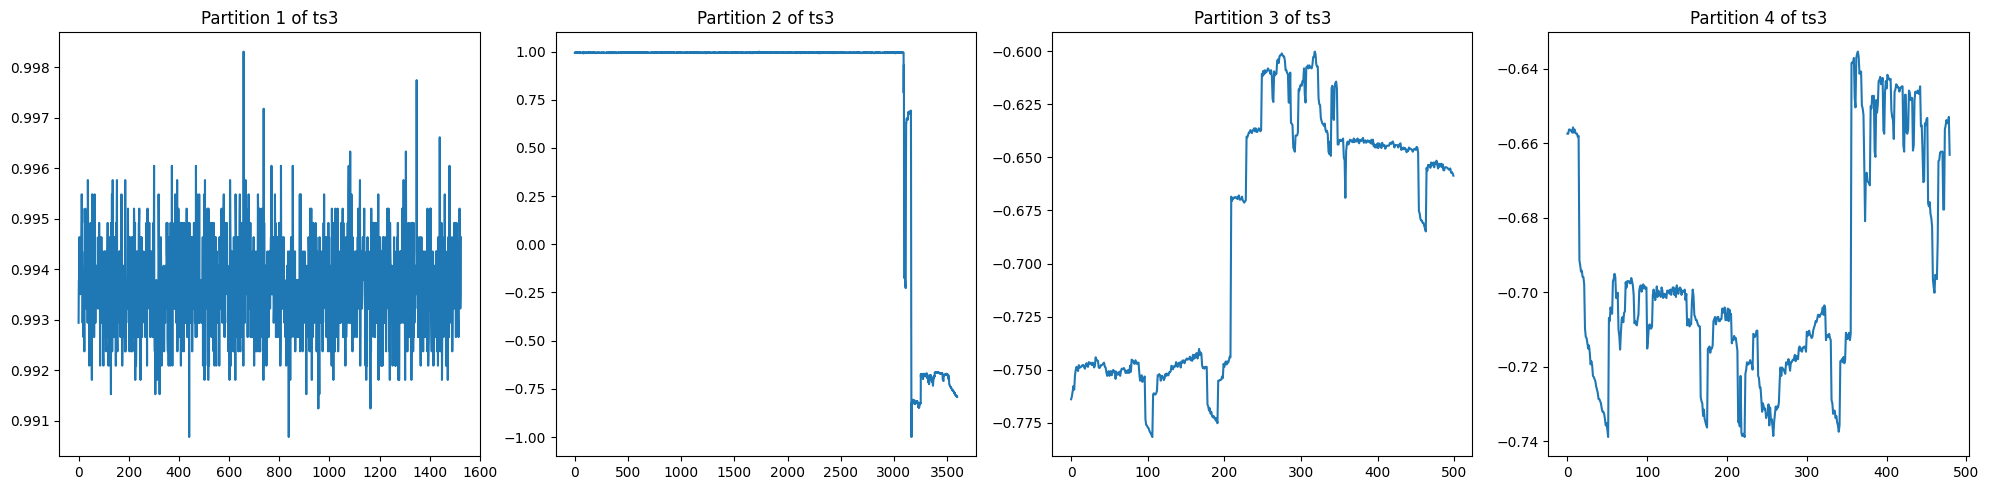

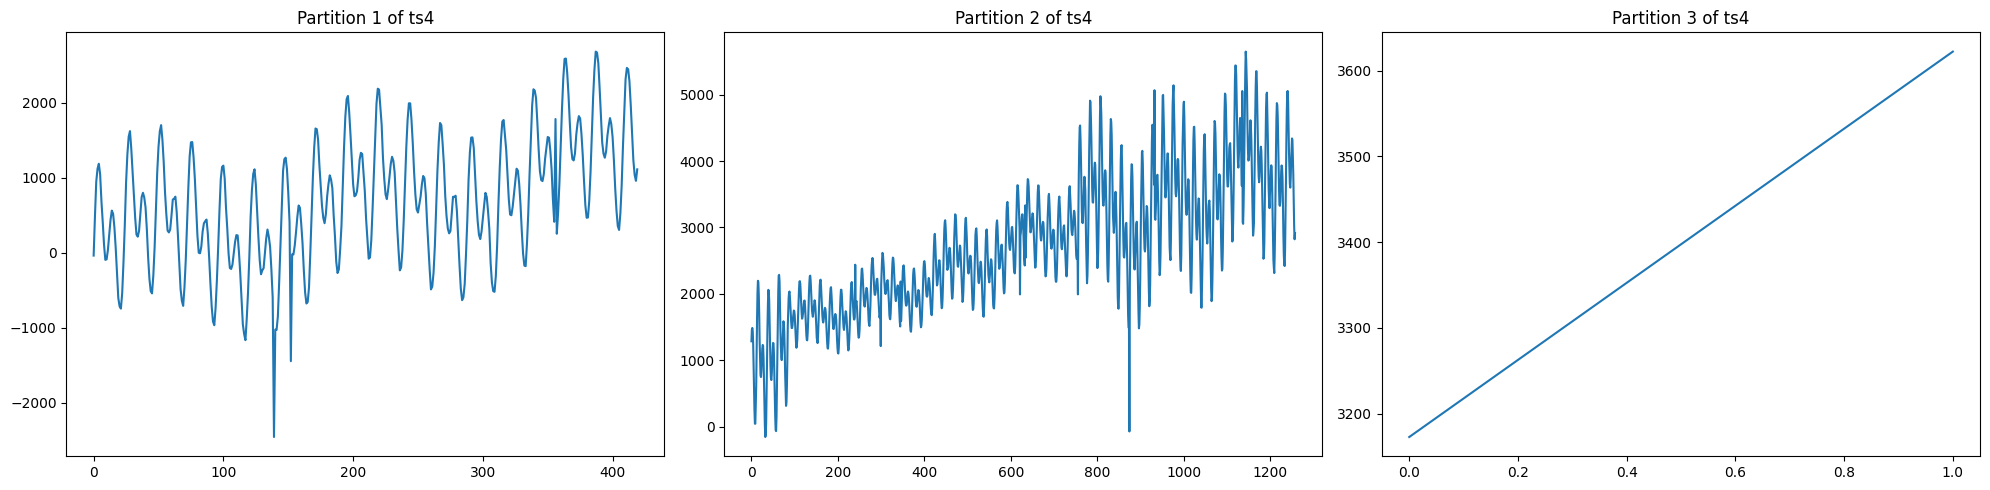

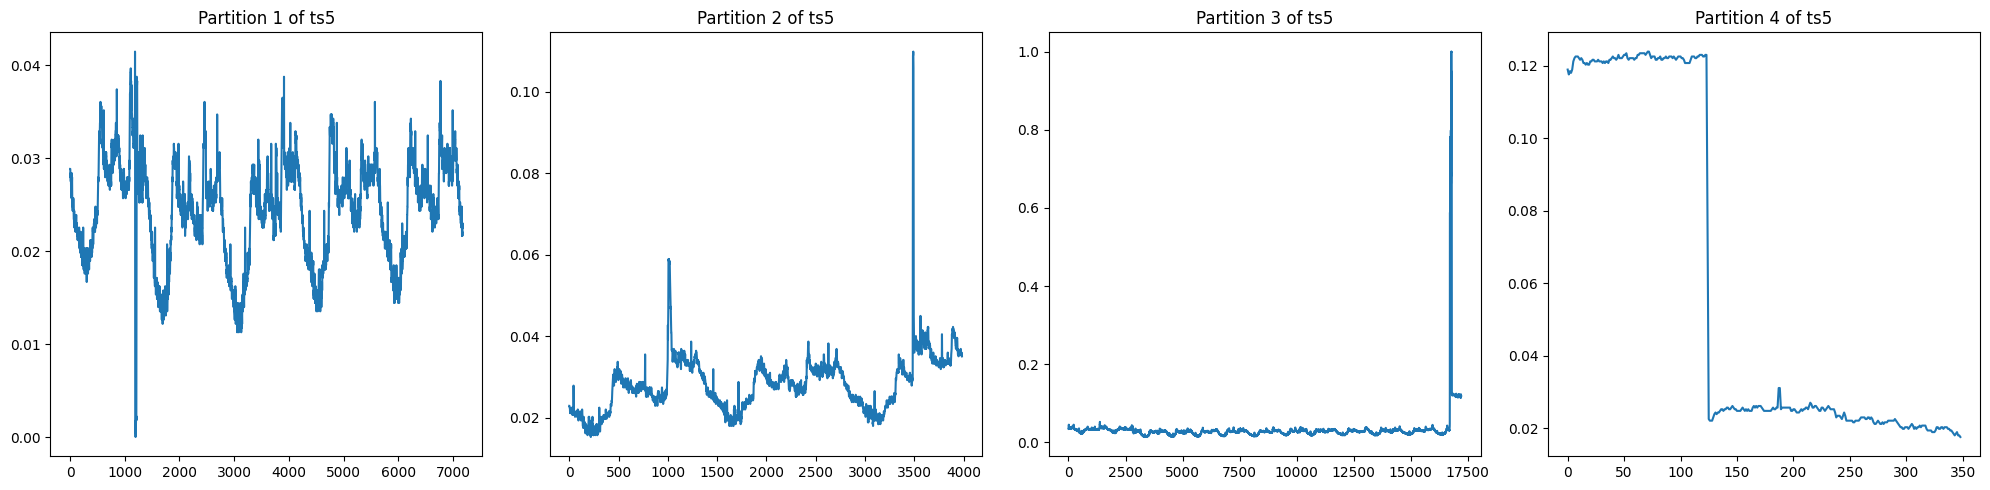

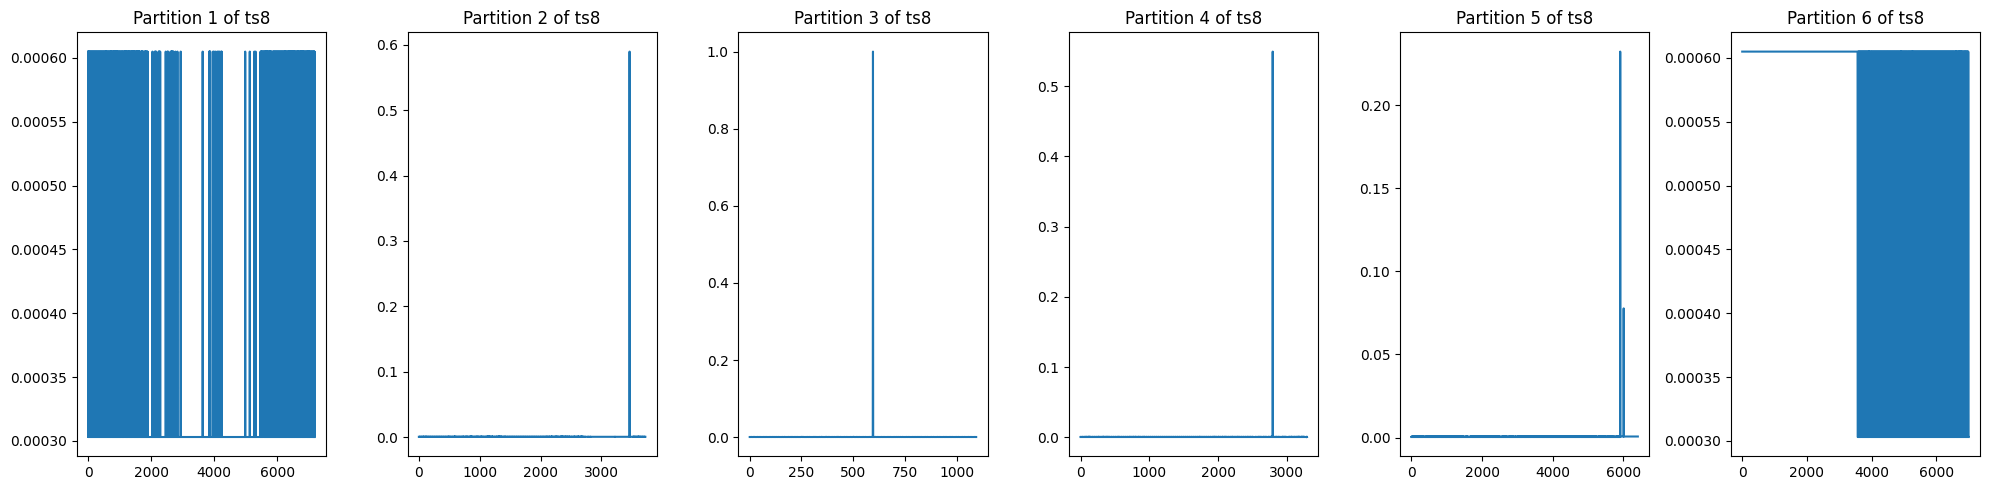

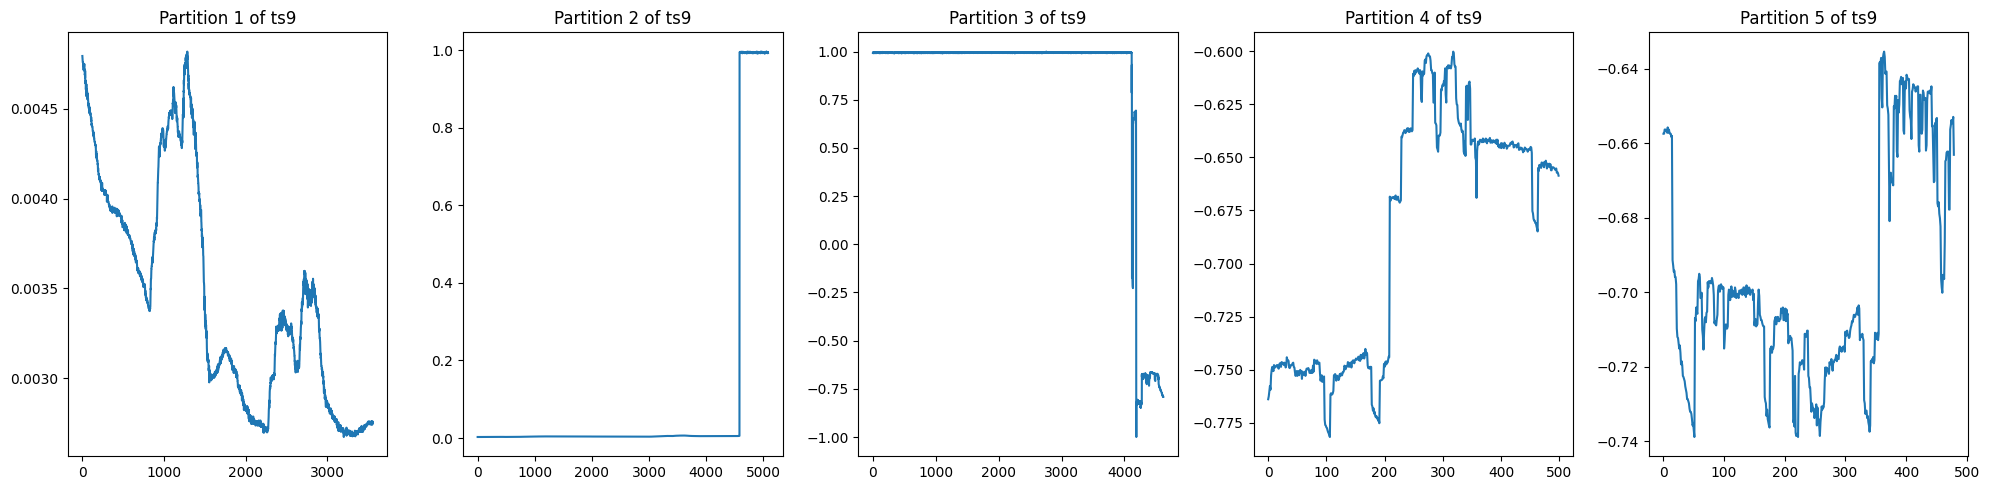

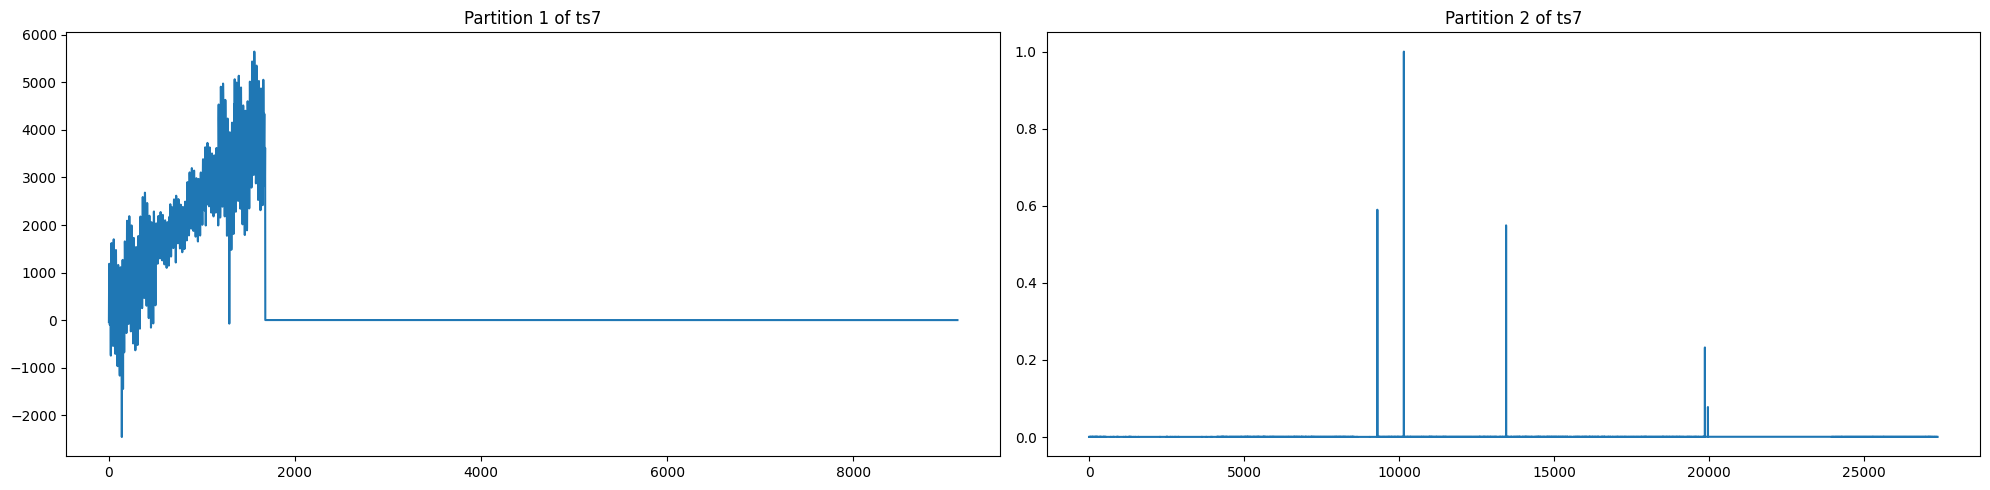

In [93]:
for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]

    if len(ts['data partitions']) < 10:

        fig, axes = plt.subplots(1, len(ts['data partitions']), figsize=(20, 5))

        for i, array in enumerate(ts['data partitions']):
            axes[i].plot(array)
            axes[i].set_title(f"Partition {i+1} of {ts['name']}")

        plt.tight_layout()
        plt.show()

#### ***Dynamic Partitioning***(Variant 2)

In [41]:
n = 3 # Define the number of partitions

In [42]:
for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised methods
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1]
    global_sw = find_length(data)

    initial_partition_length = int(len(data) * 0.25)
    initial_partition = data[:initial_partition_length]
    data_partitions = [initial_partition]
    cusum = CUSUM(mu=np.mean(initial_partition))
    remaining_data = data[initial_partition_length:]
    partition_size = len(remaining_data) // n
    remaining_points = len(remaining_data) % n

    start_idx = 0
    for i in range(n):
        end_idx = start_idx + partition_size
        if i == n - 1:
            end_idx += remaining_points

        partition = remaining_data[start_idx:end_idx]
        cusum.process(partition)
        change_points = cusum.changepoints

        if change_points:
            sub_partitions = []
            prev_cp = 0
            for cp in change_points:
                sub_partitions.append(partition[prev_cp:cp])
                prev_cp = cp
            sub_partitions.append(partition[prev_cp:])

            for sub_partition in sub_partitions:
                if len(sub_partition) > 0:
                    data_partitions.append(sub_partition)
        else:
            data_partitions.append(partition)


    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'label': label,
        'data partitions': data_partitions,
        'global_sliding_window': global_sw,
    }

Let's see the number of partitions created for each time-series.

In [43]:
for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]

    print(f"Number of partitions: {len(ts['data partitions'])} for file: {ts['name']}")

Number of partitions: 1018 for file: ts1
Number of partitions: 4 for file: ts3
Number of partitions: 43 for file: ts4
Number of partitions: 730 for file: ts5
Number of partitions: 10 for file: ts8
Number of partitions: 1439 for file: ts2
Number of partitions: 4 for file: ts9
Number of partitions: 1105 for file: ts6
Number of partitions: 4 for file: ts7


Are the partitions consistent with the initial size of the time-series?

In [44]:
for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]
    par_size = 0
    for partition in ts['data partitions']:
        par_size += len(partition)
    
    print(f"Total size of partitions: {par_size} for file: {ts['name']}. Original data size: {len(ts['data'])}")

Total size of partitions: 30356 for file: ts1. Original data size: 30356
Total size of partitions: 6100 for file: ts3. Original data size: 6100
Total size of partitions: 1680 for file: ts4. Original data size: 1680
Total size of partitions: 28726 for file: ts5. Original data size: 28726
Total size of partitions: 28705 for file: ts8. Original data size: 28705
Total size of partitions: 46186 for file: ts2. Original data size: 46186
Total size of partitions: 14243 for file: ts9. Original data size: 14243
Total size of partitions: 33487 for file: ts6. Original data size: 33487
Total size of partitions: 36485 for file: ts7. Original data size: 36485


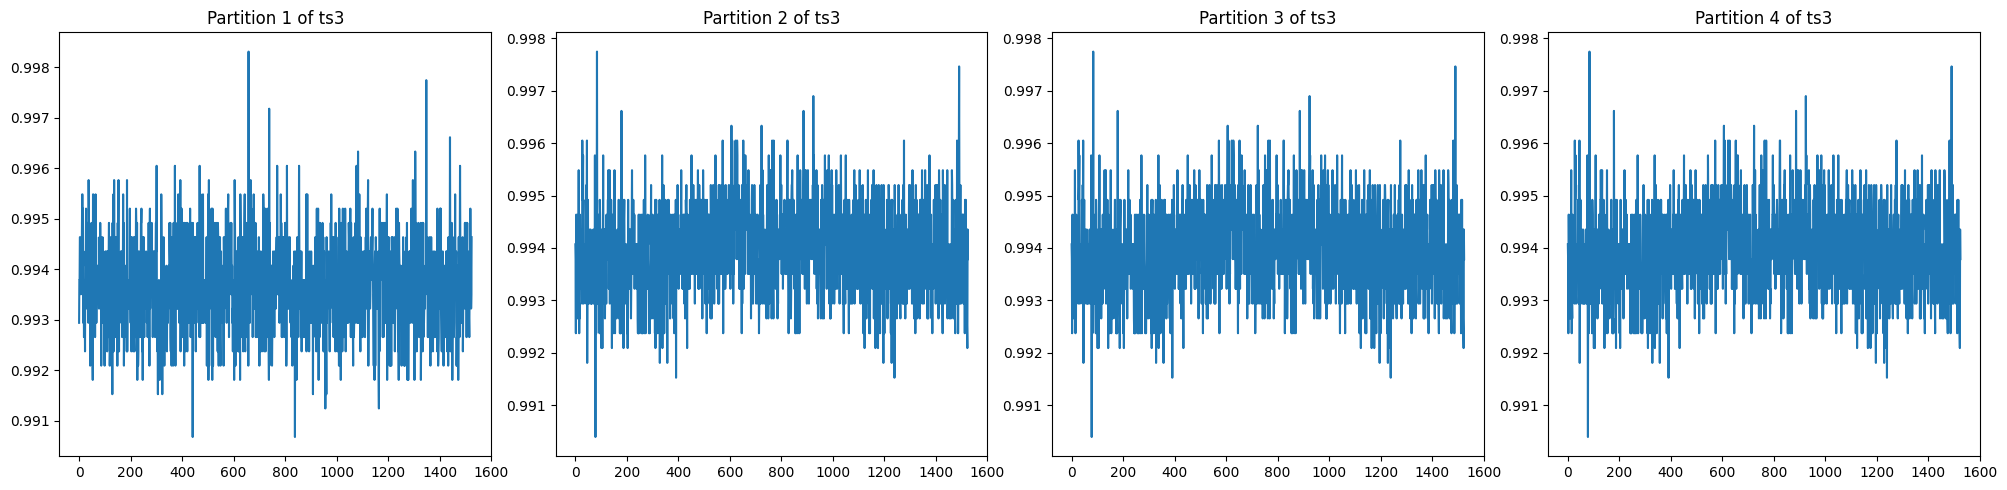

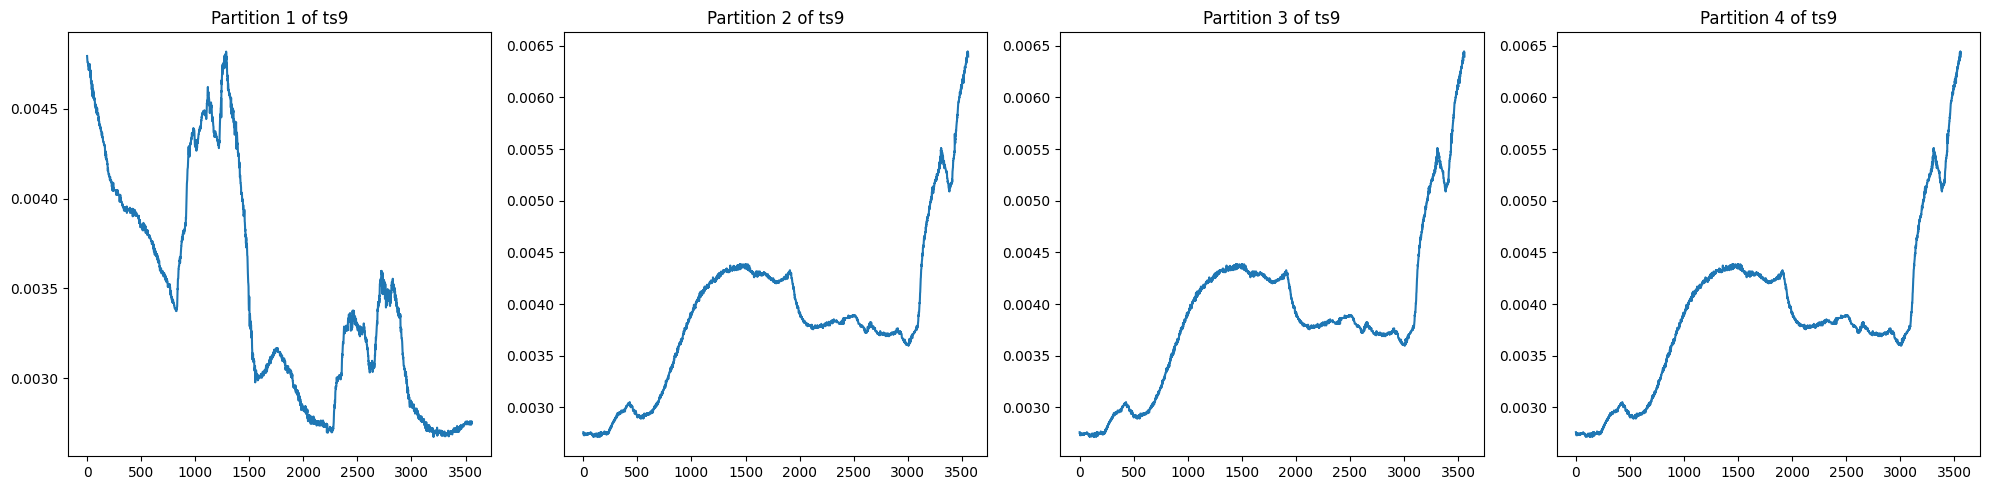

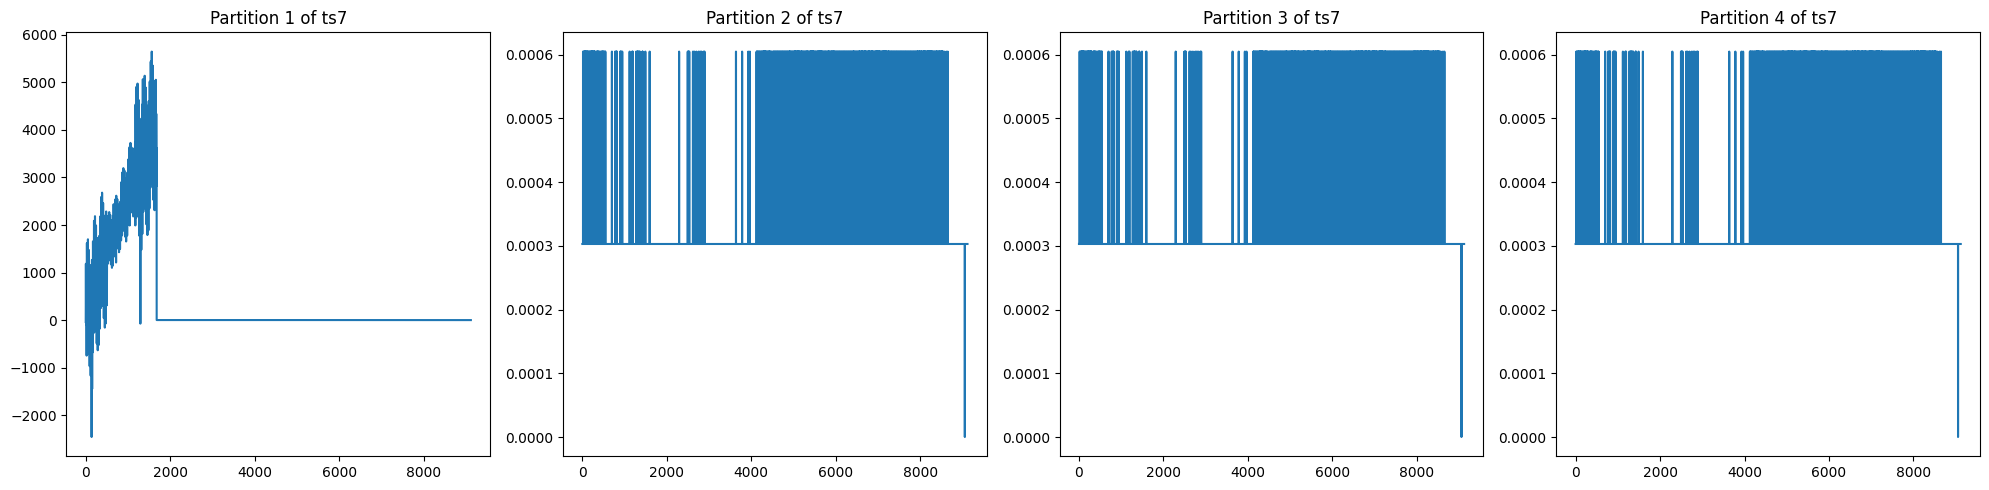

In [45]:
for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]

    if len(ts['data partitions']) < 10:

        fig, axes = plt.subplots(1, len(ts['data partitions']), figsize=(20, 5))

        for i, array in enumerate(ts['data partitions']):
            axes[i].plot(array)
            axes[i].set_title(f"Partition {i+1} of {ts['name']}")

        plt.tight_layout()
        plt.show()

### ***Plot TS length and number of abnormal points***

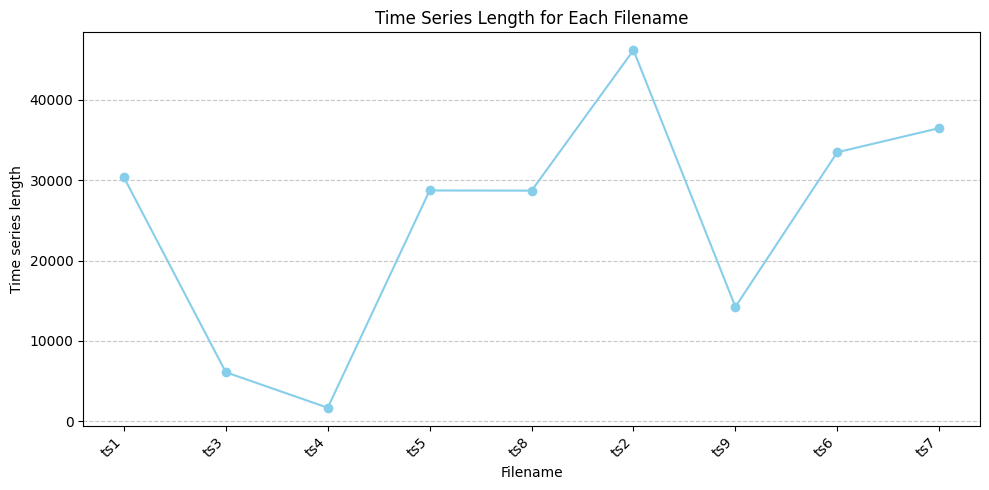

In [9]:
# Get filenames, time series lengths, and number of abnormal points
filenames = list(preprocessed_dict.keys())
time_series_lengths = [data['Time series length'] for data in preprocessed_dict.values()]
number_of_abnormal_points = [data['Number of abnormal points'] for data in preprocessed_dict.values()]

# Plot 'Time series length' and 'Number of abnormal points' for each filename
plt.figure(figsize=(10, 5))
plt.plot(filenames, time_series_lengths, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Filename')
plt.ylabel('Time series length')
plt.title('Time Series Length for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

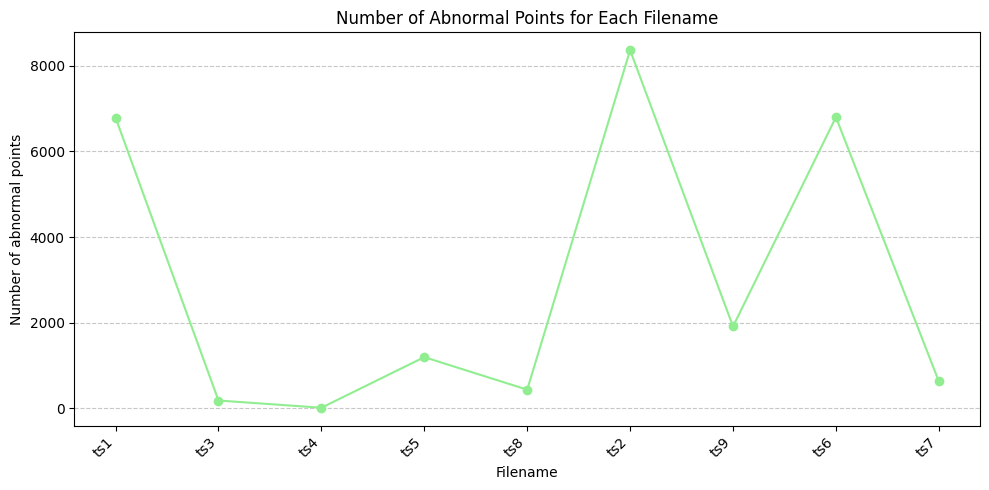

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(filenames, number_of_abnormal_points, marker='o', linestyle='-', color='lightgreen')
plt.xlabel('Filename')
plt.ylabel('Number of abnormal points')
plt.title('Number of Abnormal Points for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## ***Anomaly Detection***


Classification Information:
- TN: The point is normal and we predicted it is normal
- TP: The point is abnormal and we predicted it is abnormal
- FP: The point is normal and we predicted it is abnormal
- FN: The point is abnormal and we predicted it is normal

Define evaluation metrics

In [12]:
eval_metrics = ['AUC', 
                'Precision', 
                'Recall', 
                'F', 
                'Rrecall', 
                'ExistenceReward',
                'OverlapReward',
                'Rprecision',
                'Rf',
                'Precision@k',
                'R_AUC']

Define a function to colorize the cells of the dataframe results 

In [13]:
def highlight_diff(val):
    color = ''
    if val > 0:
        color = 'background-color: lightgreen'
    elif val < 0:
        color = 'background-color: lightcoral'
    return color

### ***Isolation Forest***(Original)
Non-Streaming Variant

In [11]:
modelName = 'IForest'
clf = IForest(n_jobs=1, random_state=42)

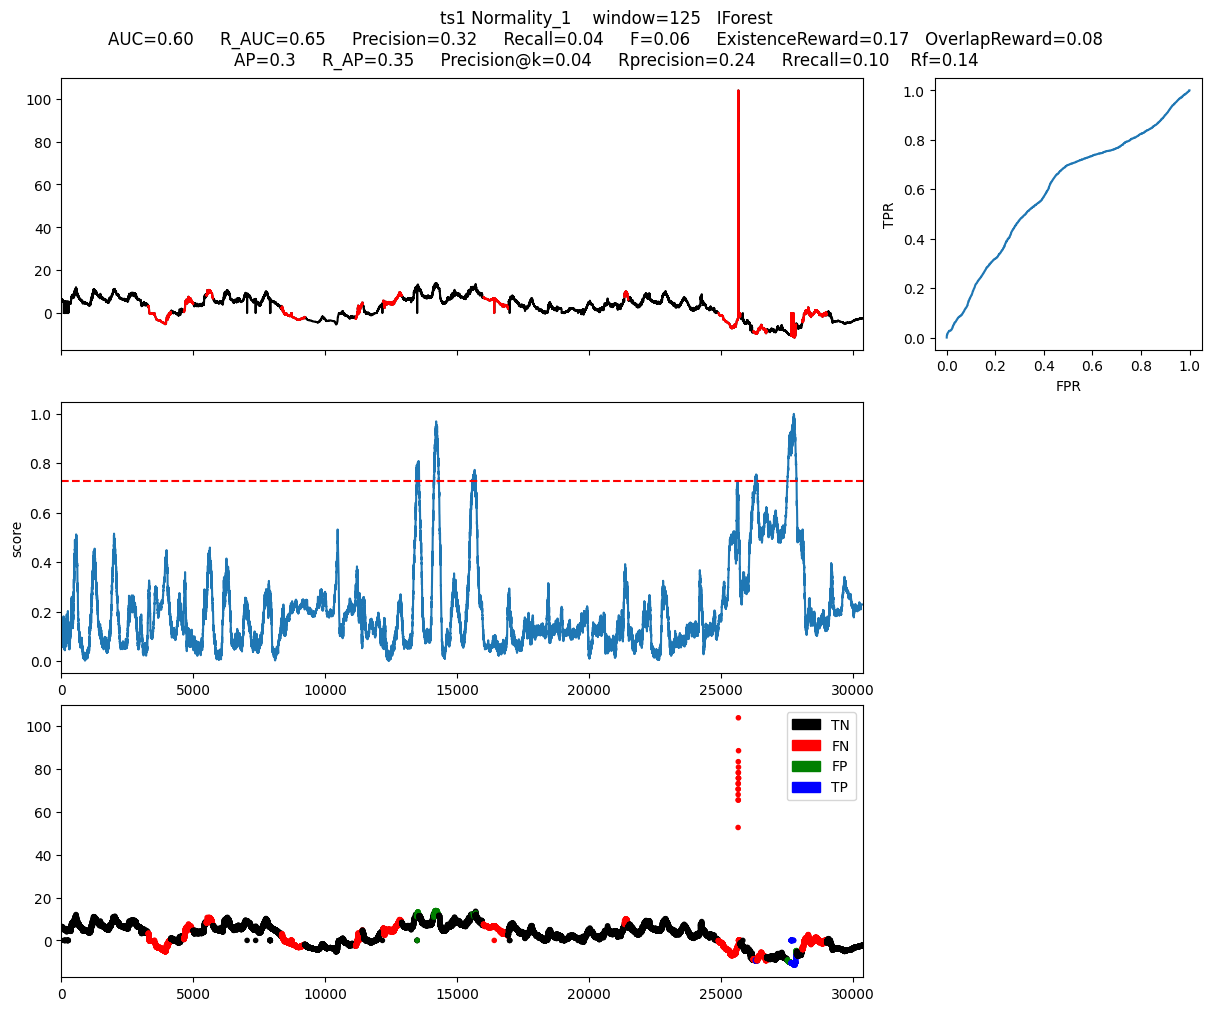

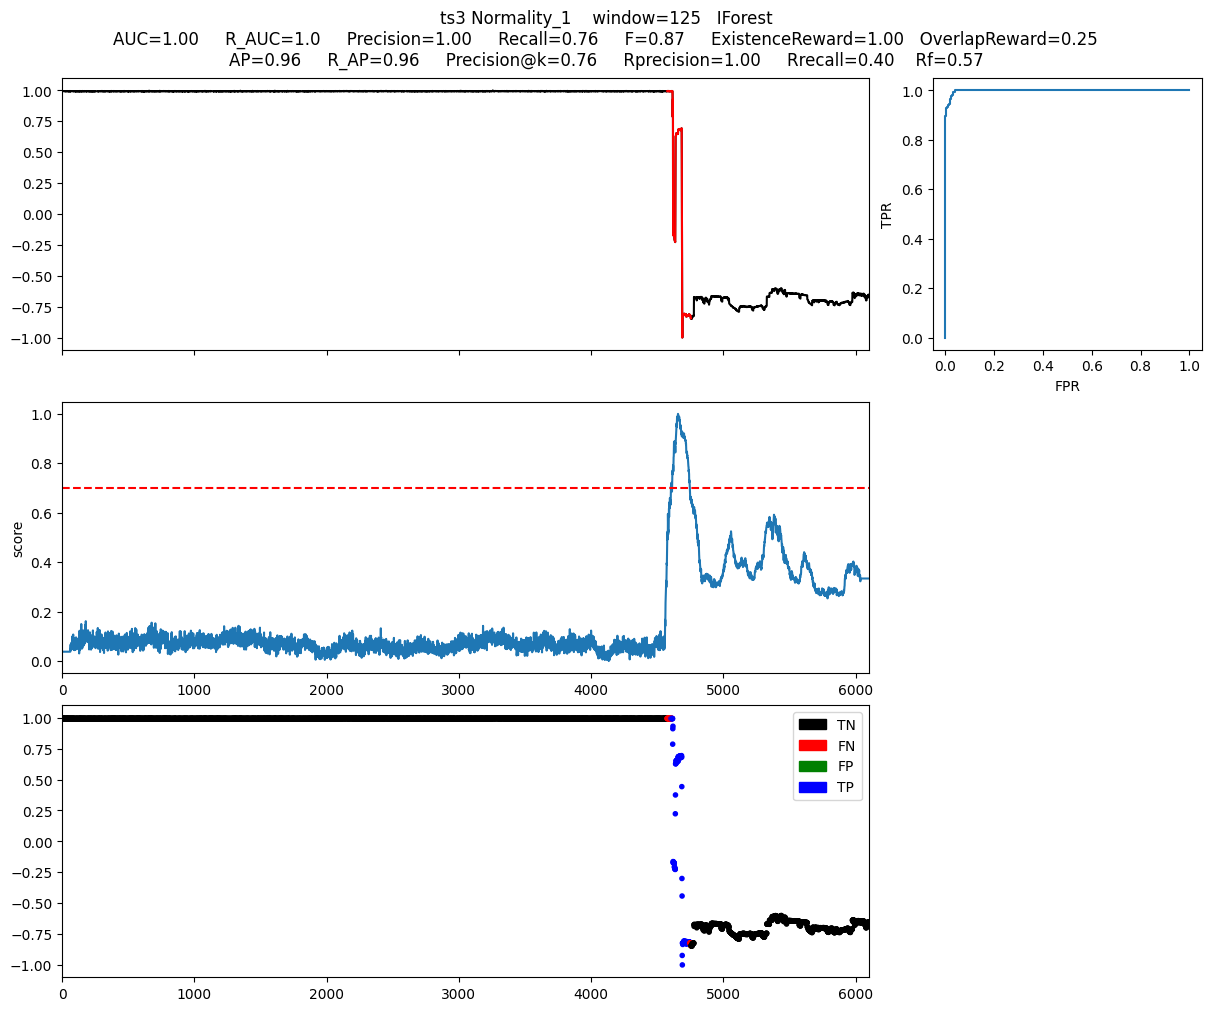

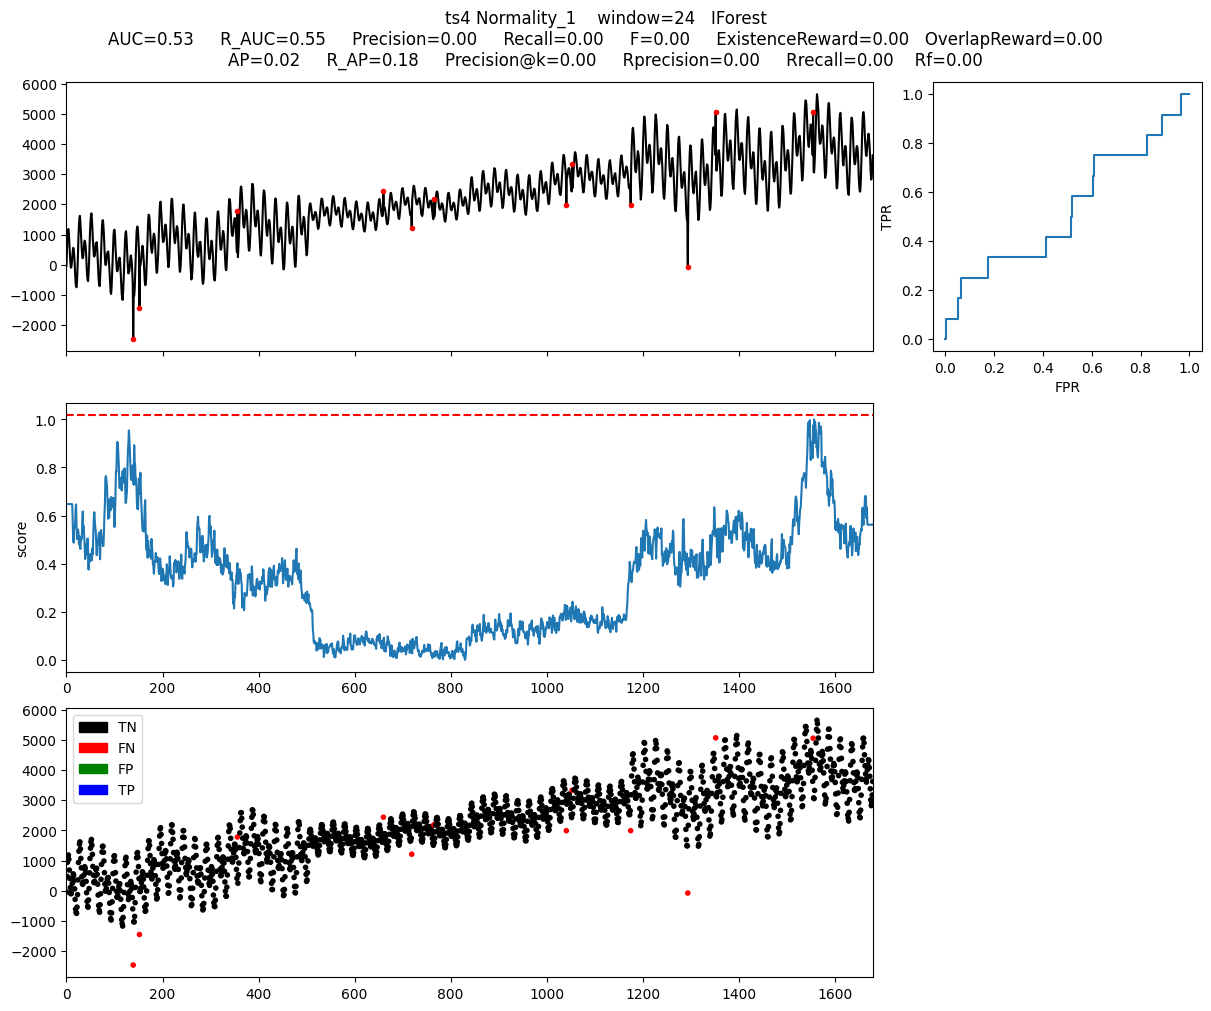

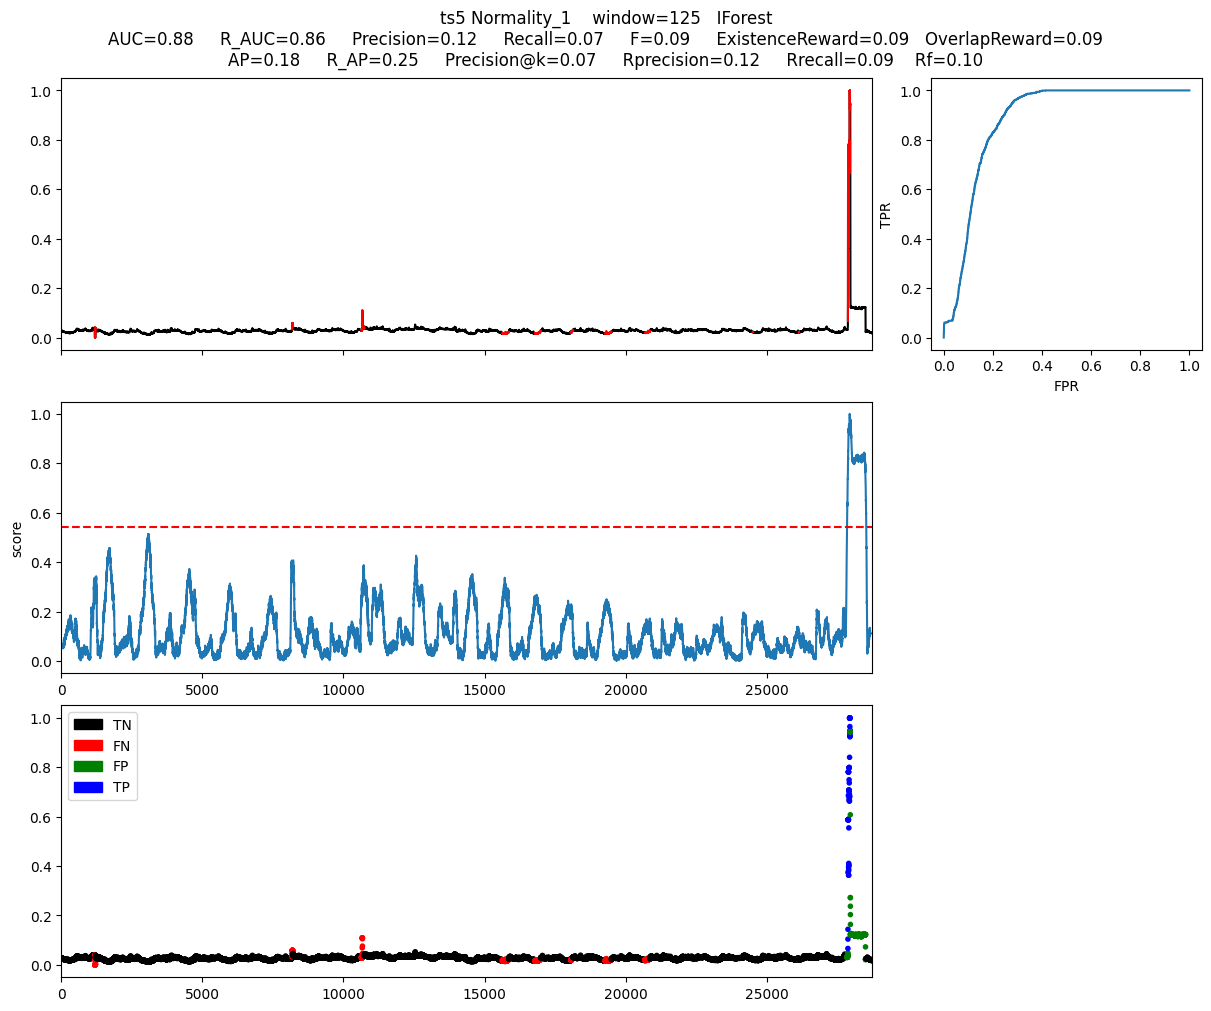

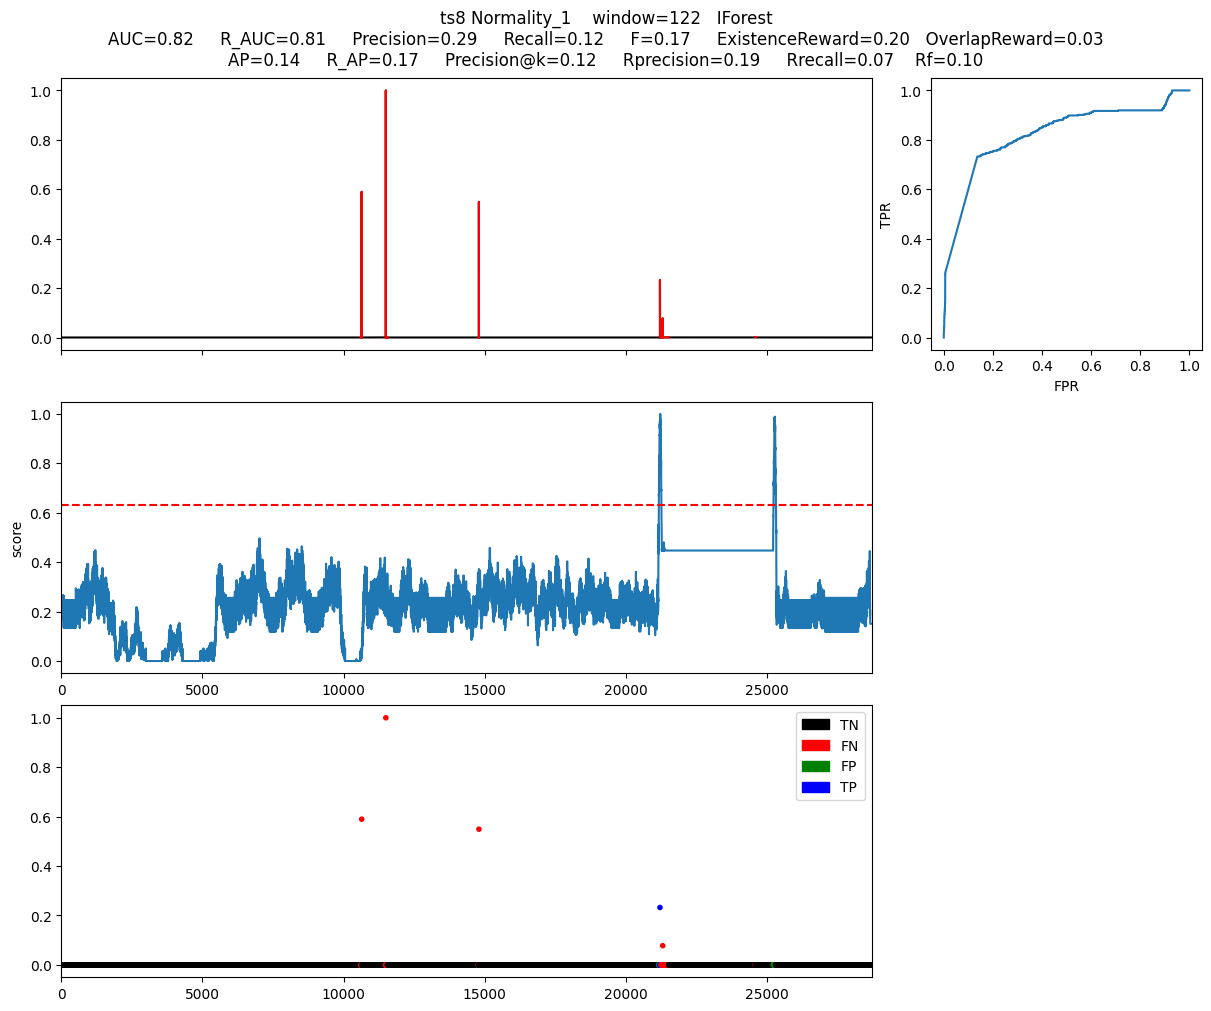

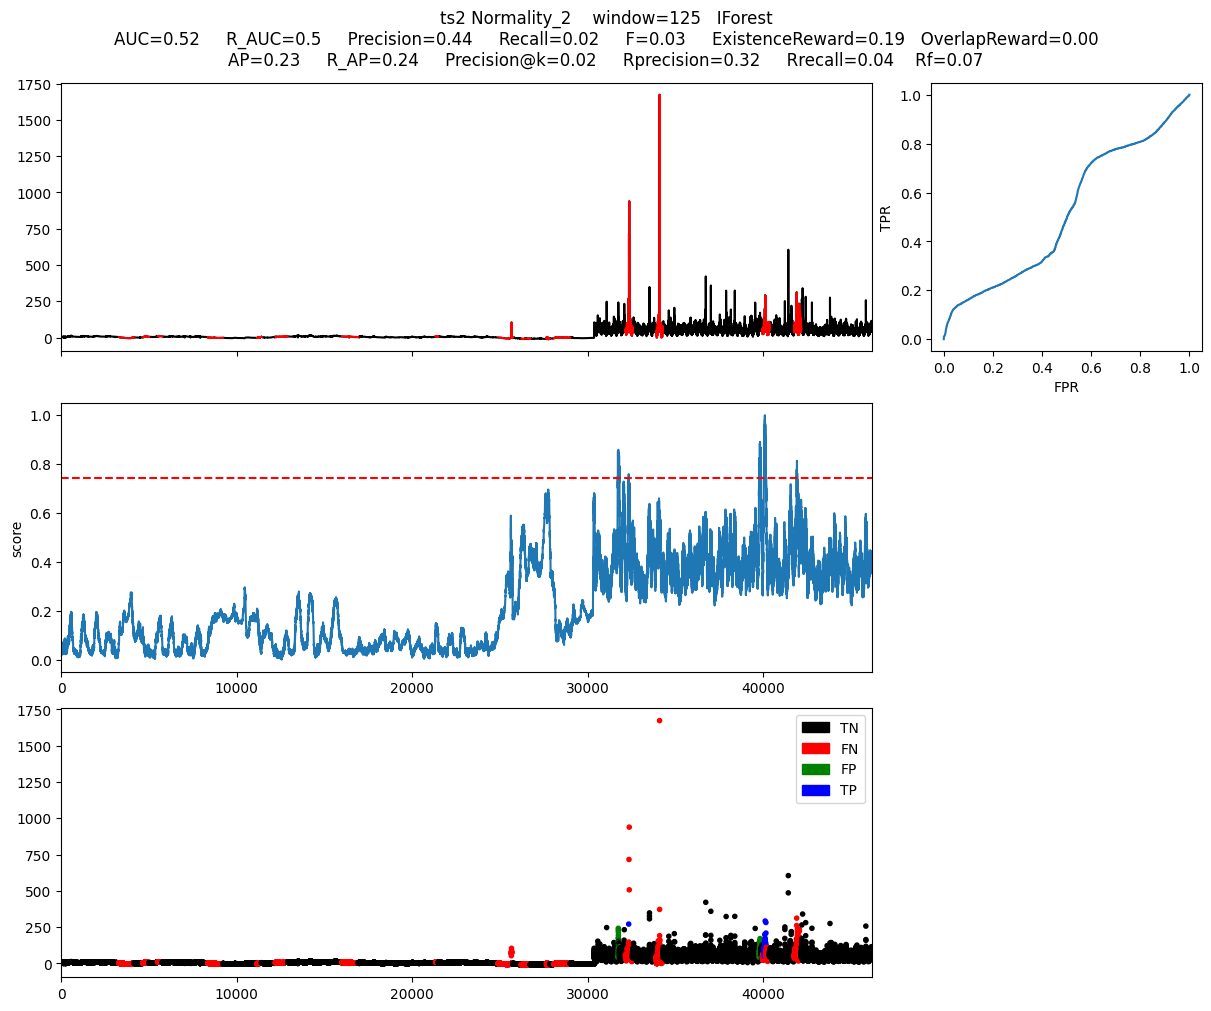

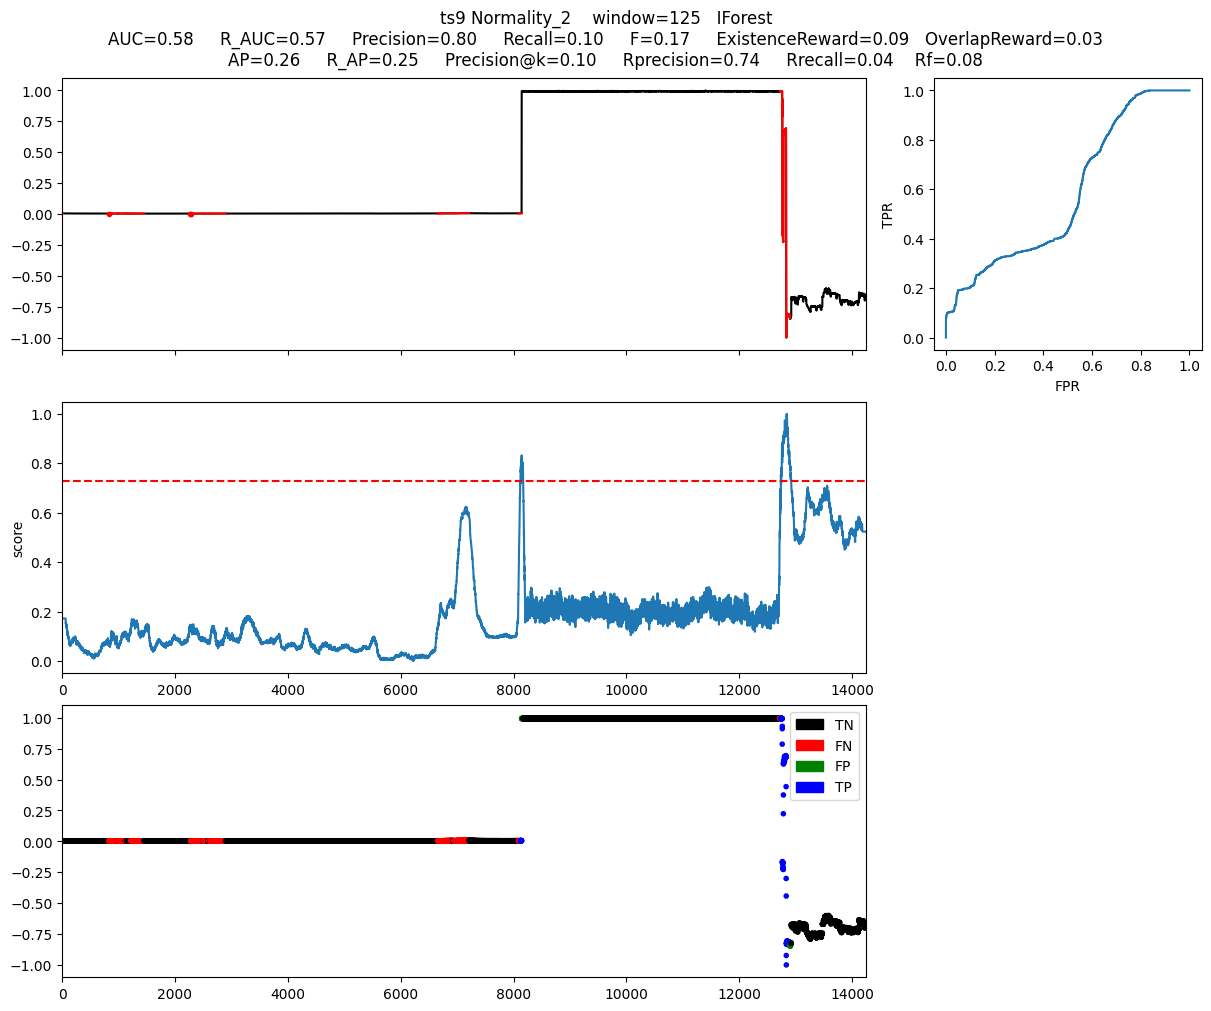

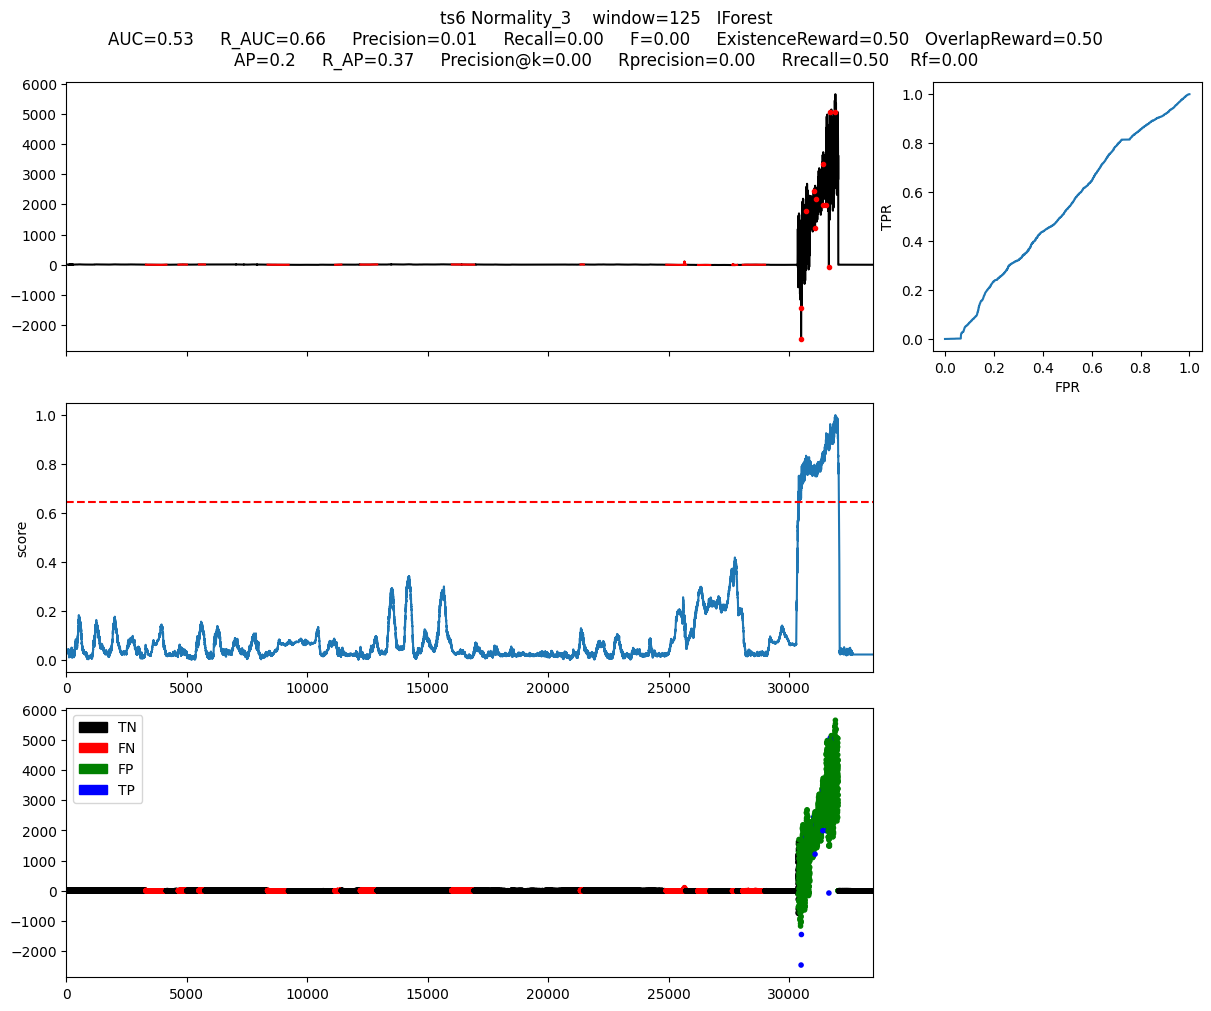

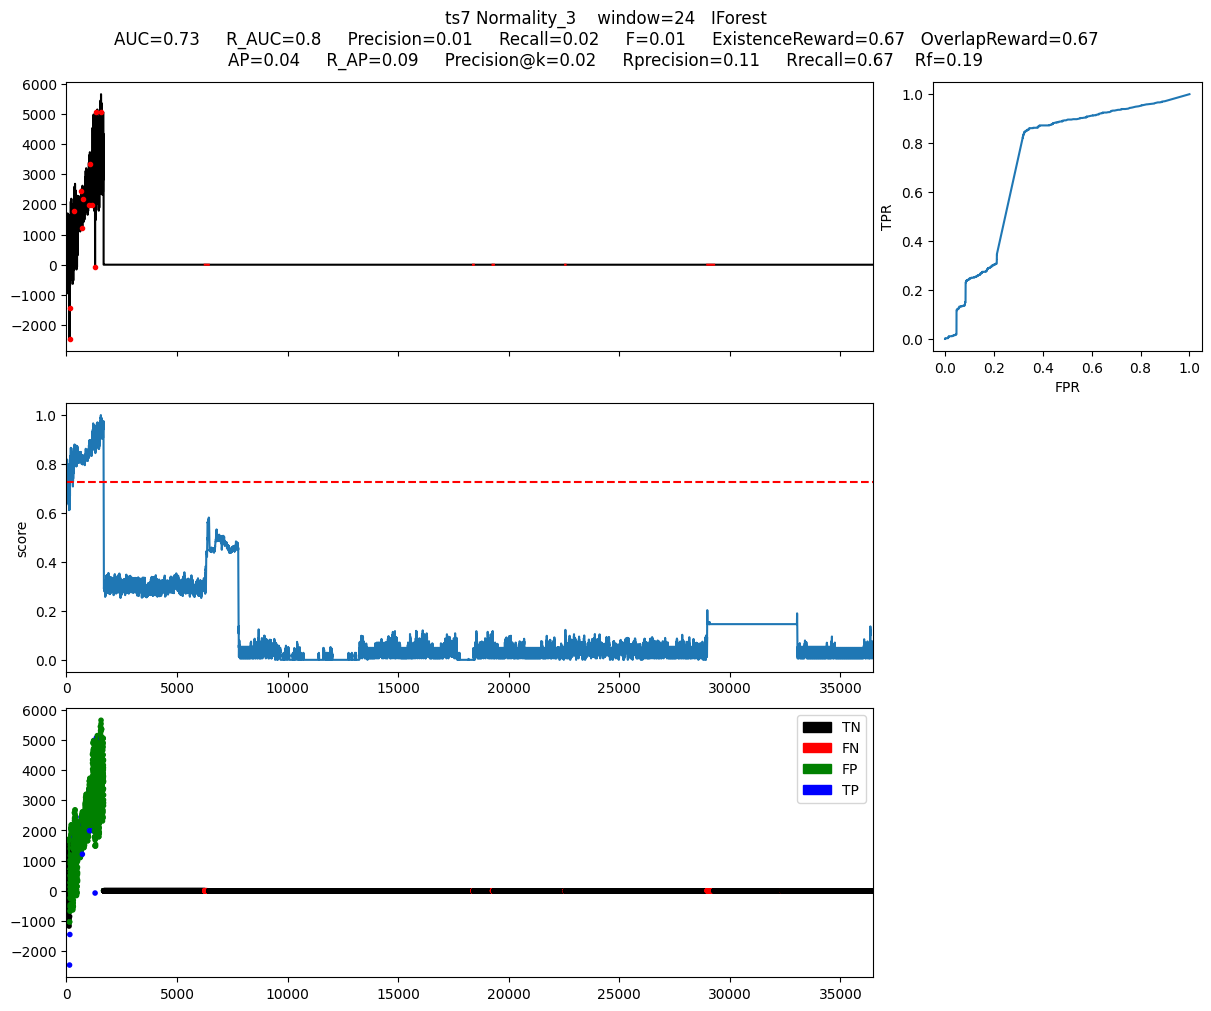

In [12]:
results = []

for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]
    x = ts['X_data']
    clf.fit(x)
    
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((ts['slidingWindow']-1)/2) + list(score) + [score[-1]]*((ts['slidingWindow']-1)//2))
    
    # Plot figure
    plotFig(ts['data'], ts['label'], score, ts['slidingWindow'], fileName=ts['name'] + ' ' + loaded_dict[ts['name']][0], modelName=modelName)

    # Calculate the results
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    L = [ '%.2f' % elem for elem in L]
    results.append([filename] + L)

In [22]:
columns = ['Filename'] + eval_metrics
iforest_res = pd.DataFrame(results, columns=columns)

In [23]:
iforest_res

Filename   AUC Precision Recall     F Rrecall ExistenceReward OverlapReward  \
0      ts1  0.58      0.31   0.03  0.06    0.10            0.17          0.08   
1      ts3  1.00      1.00   0.78  0.88    0.51            1.00          0.39   
2      ts4  0.51      0.00   0.00  0.00    0.00            0.00          0.00   
3      ts5  0.87      0.12   0.07  0.09    0.09            0.09          0.09   
4      ts8  0.83      0.31   0.12  0.18    0.07            0.20          0.03   
5      ts2  0.51      0.45   0.02  0.03    0.04            0.19          0.00   
6      ts9  0.52      0.84   0.08  0.15    0.04            0.09          0.03   
7      ts6  0.55      0.01   0.00  0.00    0.50            0.50          0.50   
8      ts7  0.73      0.01   0.02  0.01    0.61            0.61          0.61   

  Rprecision    Rf Precision@k R_AUC  
0       0.28  0.15        0.03  0.64  
1       1.00  0.68        0.78  1.00  
2       0.00  0.00        0.00  0.56  
3       0.12  0.10        0.07  0.86  
4       0.20  0.10        0.12  0.83  
5       0.47  0.07        0.02  0.50  
6       0.59  0.07        0.08  0.50  
7       0.00  0.00        0.00  0.68  
8       0.03  0.06        0.02  0.80

In [25]:
iforest_res.to_csv('Results/Isolation-Forest/IForest_Non-Streaming.csv', index=False)

### ***Isolation Forest***(Variant 1)
Naive Streaming Variant

In [24]:
modelName = 'IForest'
clf = IForest(n_jobs=1, random_state=42)

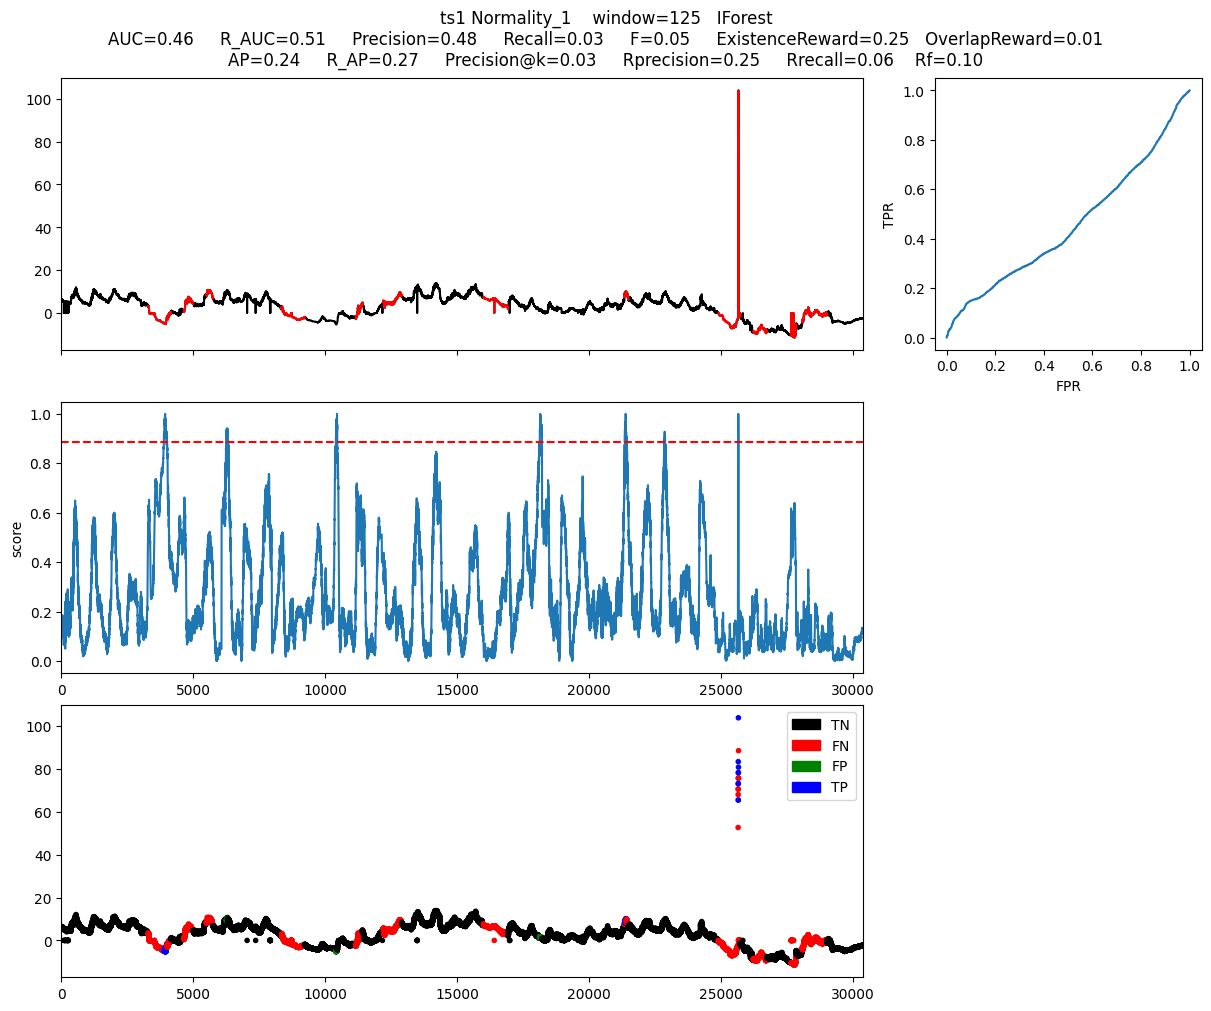

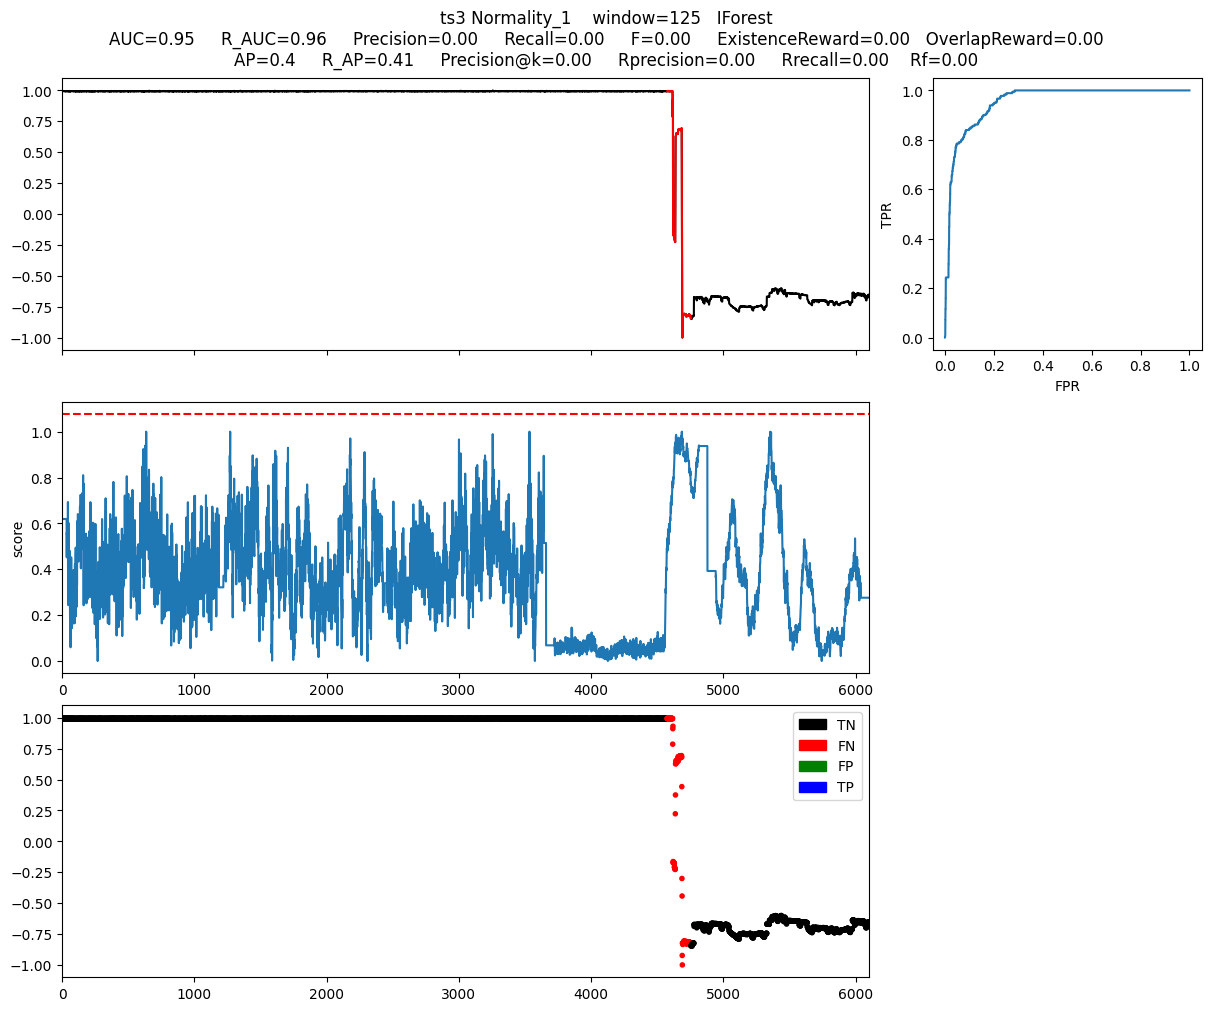

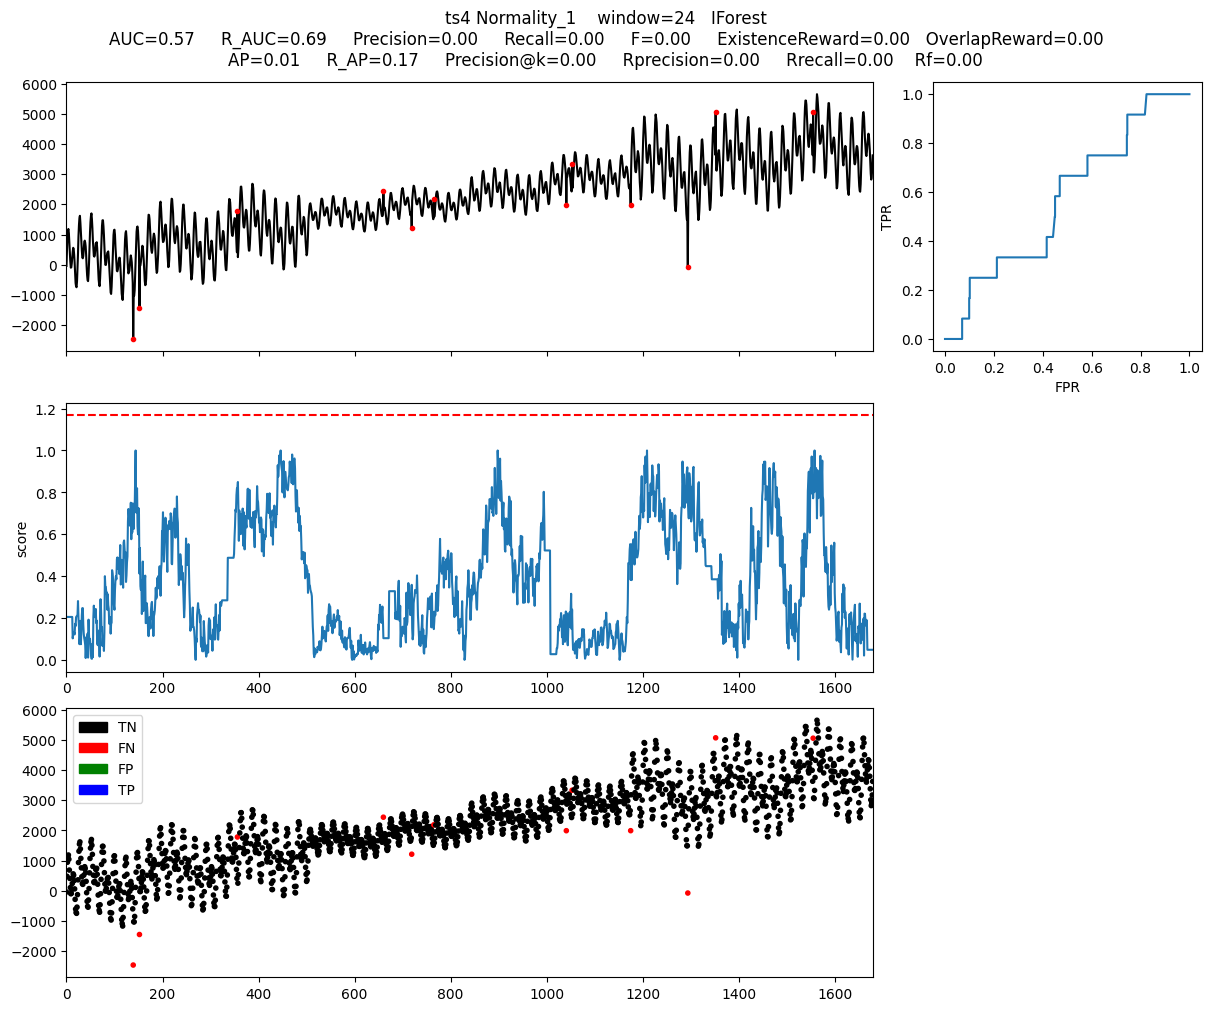

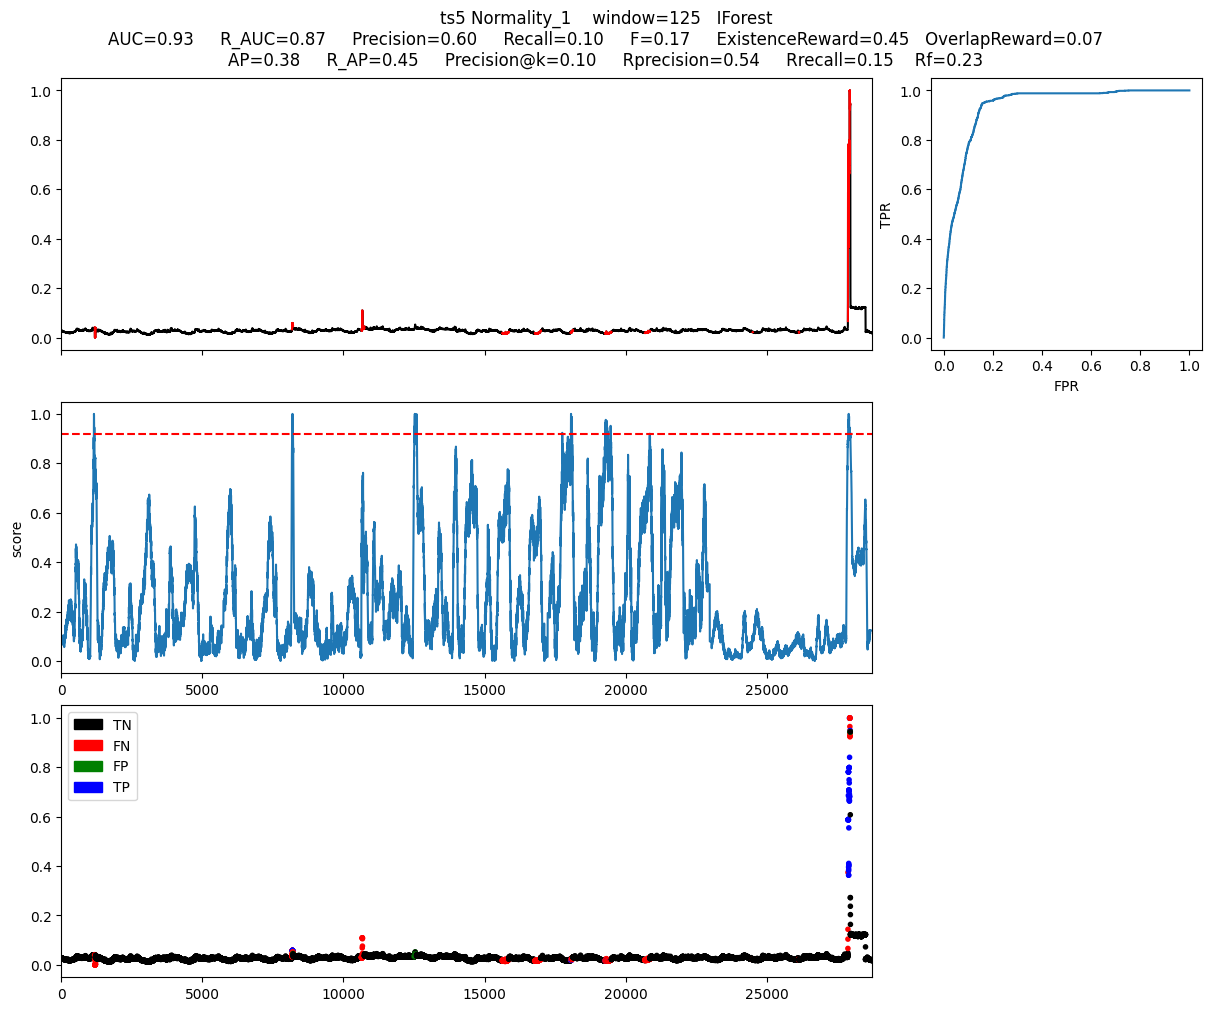

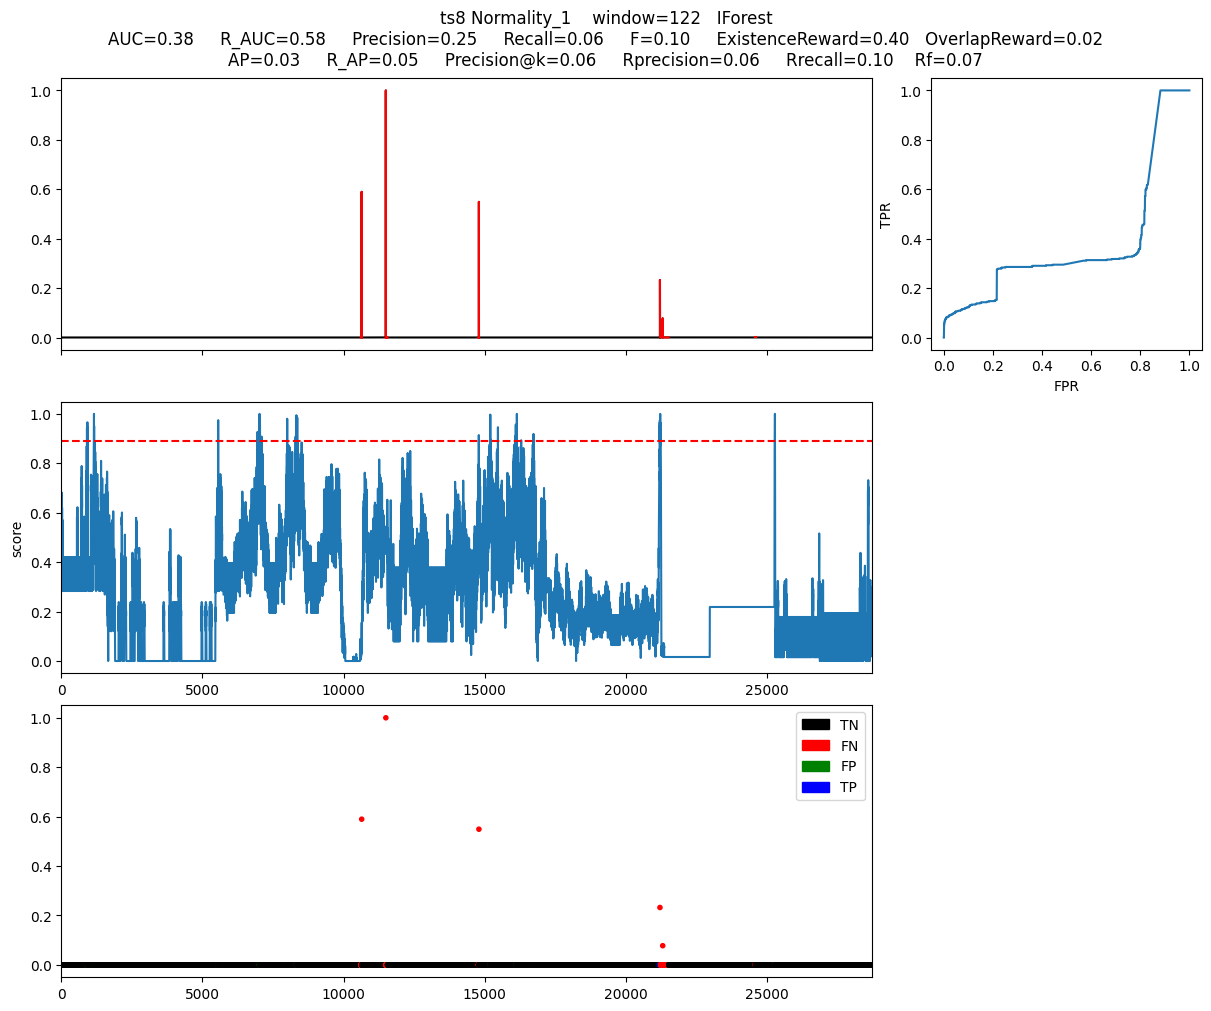

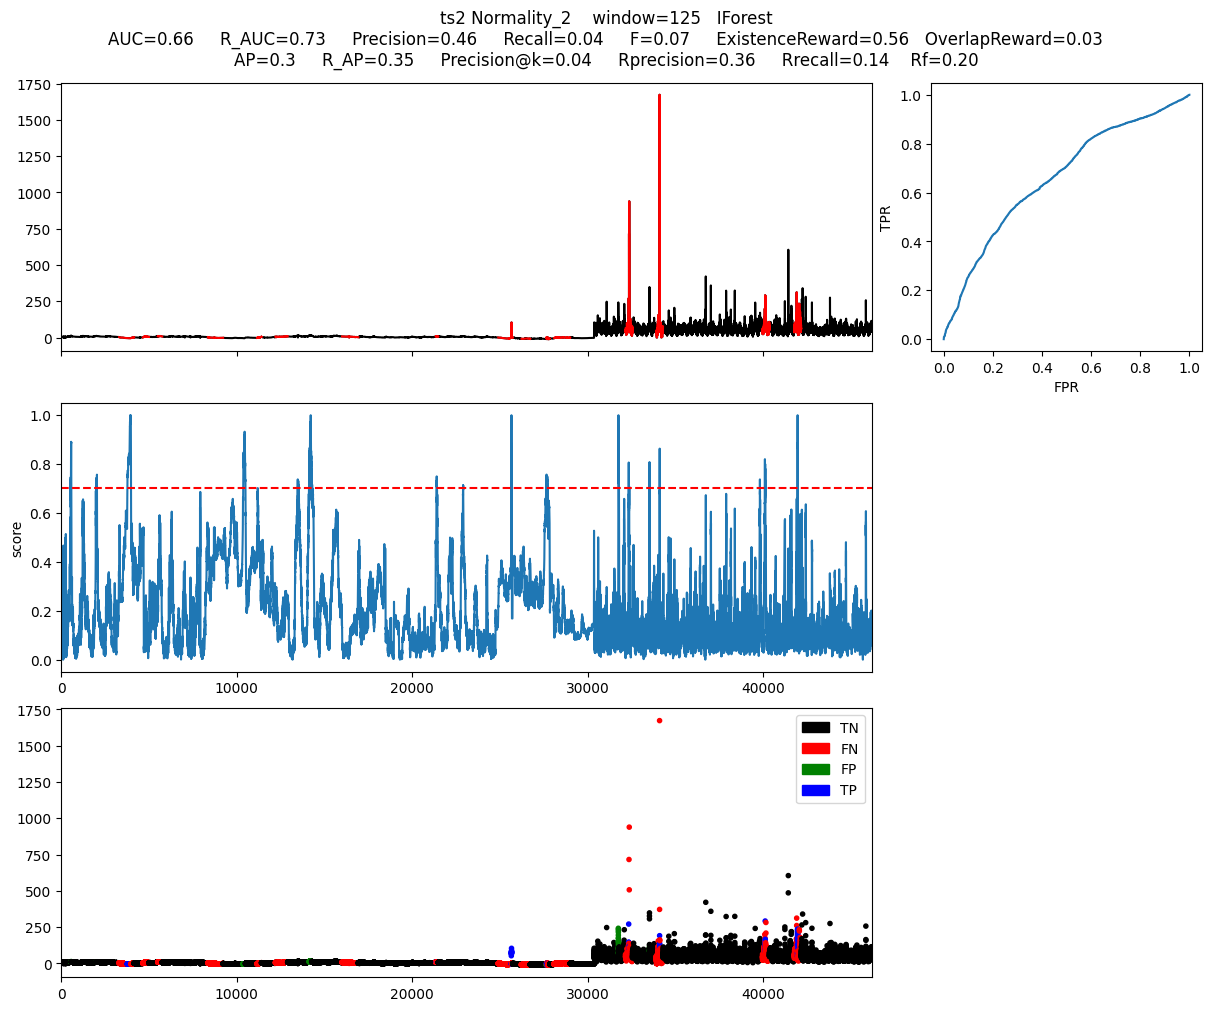

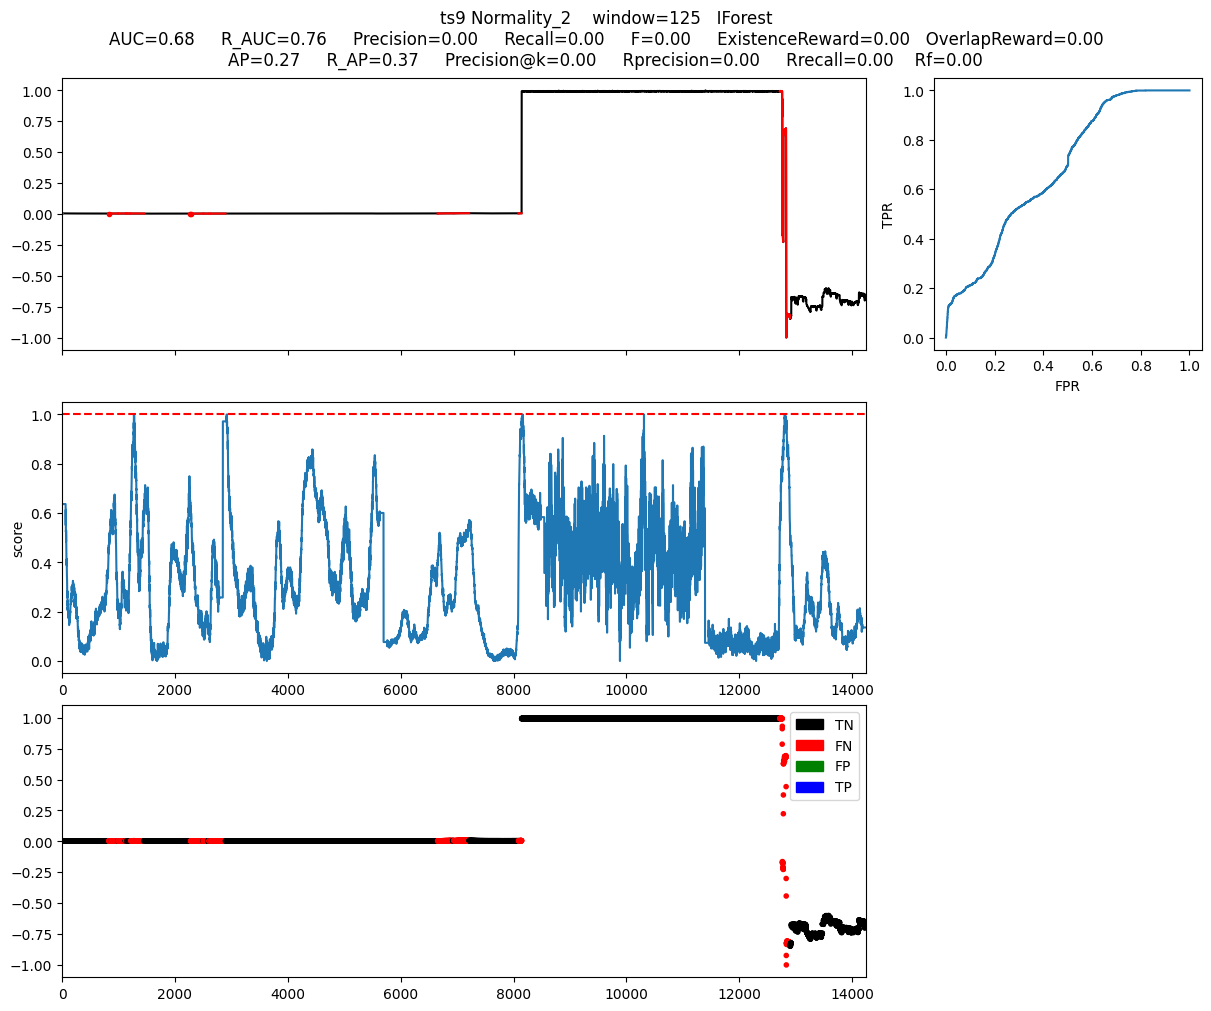

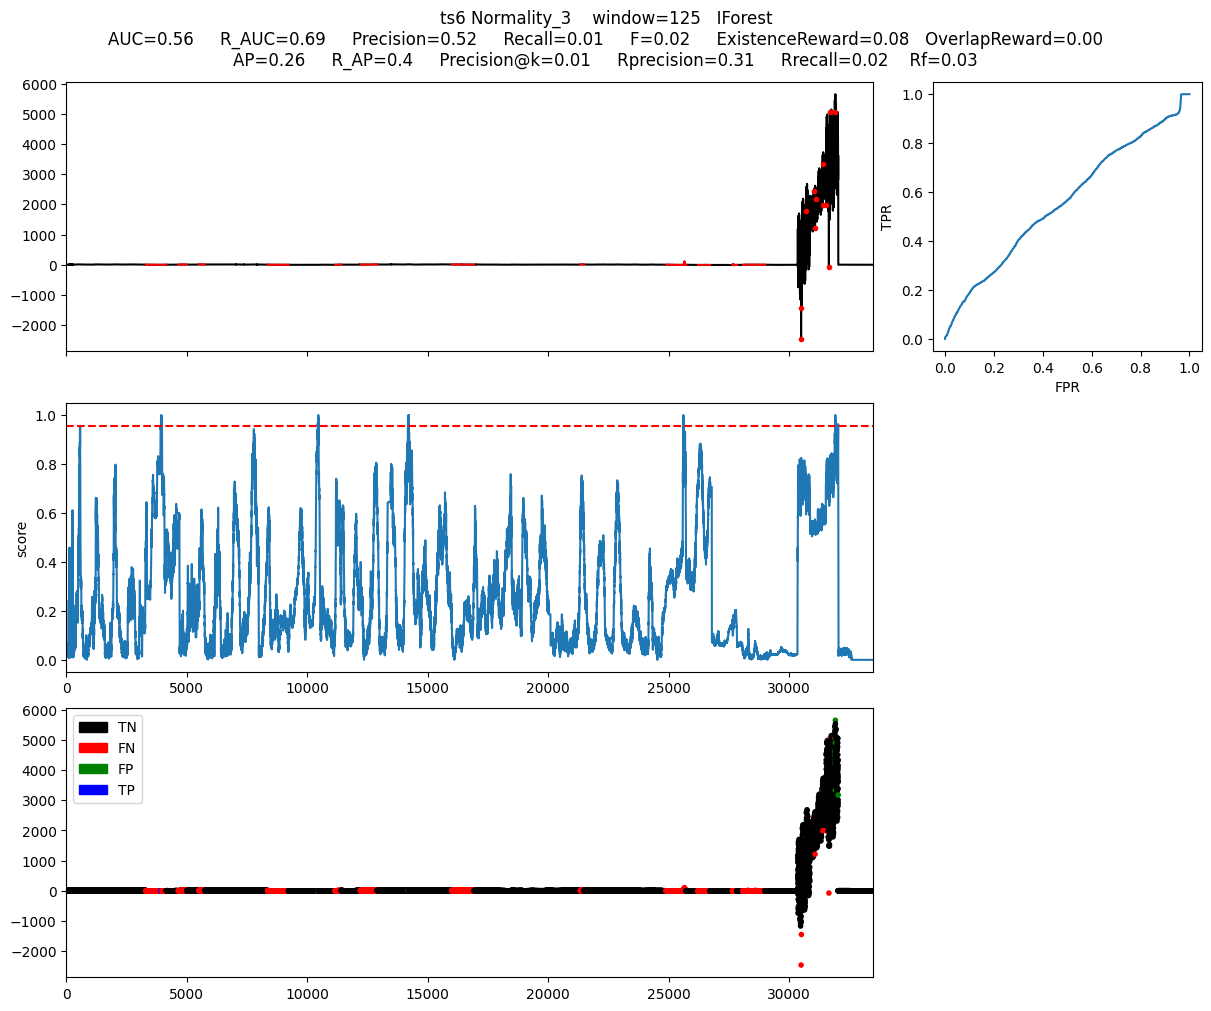

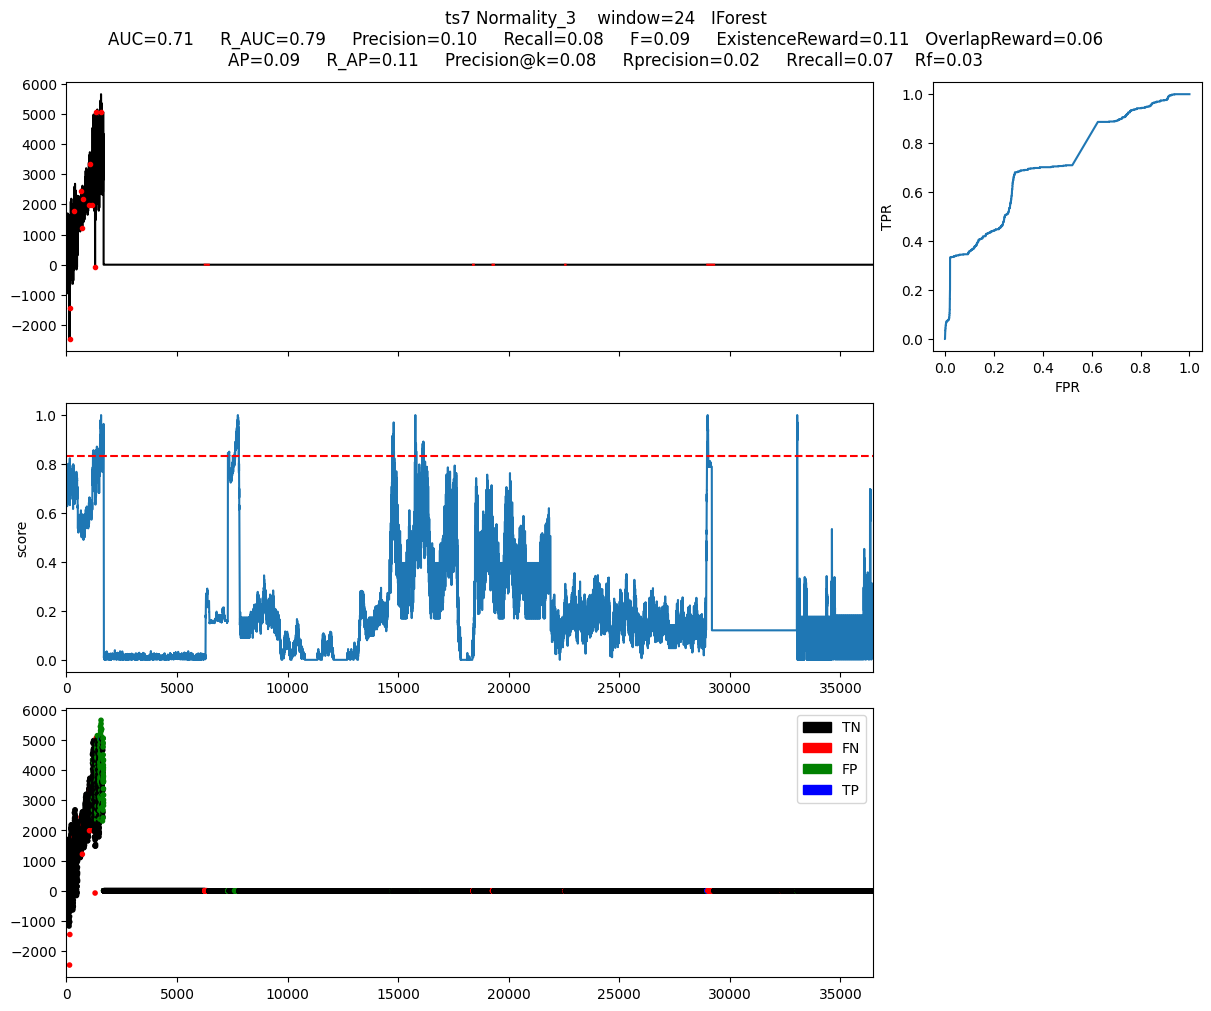

In [26]:
results = []

for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]

    scores = []
    for par in range(n):

        clf.fit(ts['X_data'][par])
        score = clf.decision_scores_
    
        score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
        score = np.array([score[0]]*math.ceil((ts['slidingWindow'][par]-1)/2) + list(score) + [score[-1]]*((ts['slidingWindow'][par]-1)//2))
        
        scores.extend(score)
    
    scores = np.array(scores)
    # Plot figure
    plotFig(ts['data'], ts['label'], scores, ts['global_sliding_window'], fileName=ts['name'] + ' ' + loaded_dict[ts['name']][0], modelName=modelName)

    # Calculate the results
    L = printResult(ts['data'], ts['label'], scores, ts['global_sliding_window'], ts['name'], modelName)
    L = [ '%.2f' % elem for elem in L]
    results.append([filename] + L)

In [27]:
columns = ['Filename'] + eval_metrics
iforest_res = pd.DataFrame(results, columns=columns)

In [28]:
iforest_res

Filename   AUC Precision Recall     F Rrecall ExistenceReward OverlapReward  \
0      ts1  0.46      0.48   0.03  0.05    0.06            0.25          0.01   
1      ts3  0.95      0.00   0.00  0.00    0.00            0.00          0.00   
2      ts4  0.57      0.00   0.00  0.00    0.00            0.00          0.00   
3      ts5  0.93      0.60   0.10  0.17    0.15            0.45          0.07   
4      ts8  0.38      0.25   0.06  0.10    0.10            0.40          0.02   
5      ts2  0.66      0.46   0.04  0.07    0.14            0.56          0.03   
6      ts9  0.68      0.00   0.00  0.00    0.00            0.00          0.00   
7      ts6  0.56      0.52   0.01  0.02    0.02            0.08          0.00   
8      ts7  0.71      0.10   0.08  0.09    0.07            0.11          0.06   

  Rprecision    Rf Precision@k R_AUC  
0       0.25  0.10        0.03  0.51  
1       0.00  0.00        0.00  0.96  
2       0.00  0.00        0.00  0.69  
3       0.54  0.23        0.10  0.87  
4       0.06  0.07        0.06  0.58  
5       0.36  0.20        0.04  0.73  
6       0.00  0.00        0.00  0.76  
7       0.31  0.03        0.01  0.69  
8       0.02  0.03        0.08  0.79

In [29]:
iforest_res.to_csv('Results/Isolation-Forest/IForest_Streaming_Naive_Variant.csv', index=False)

In [35]:
iforest_orig_res = pd.read_csv('Results/Isolation-Forest/IForest_Non-Streaming.csv')
iforest_stream_var1_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Naive_Variant.csv')

filenames_col = iforest_orig_res.iloc[:,0]

iforest_orig_res = iforest_orig_res.iloc[:, 1:]
iforest_stream_var1_res = iforest_stream_var1_res.iloc[:, 1:]

In [36]:
res_diff =  iforest_stream_var1_res - iforest_orig_res

res_diff.insert(0, 'Filename', filenames_col)

res_diff = res_diff.style.applymap(highlight_diff, subset=pd.IndexSlice[:, res_diff.columns[1:]])

res_diff

### ***Isolation Forest***(Variant 2)
Streaming variant with batch history

In [12]:
modelName = 'IForest'

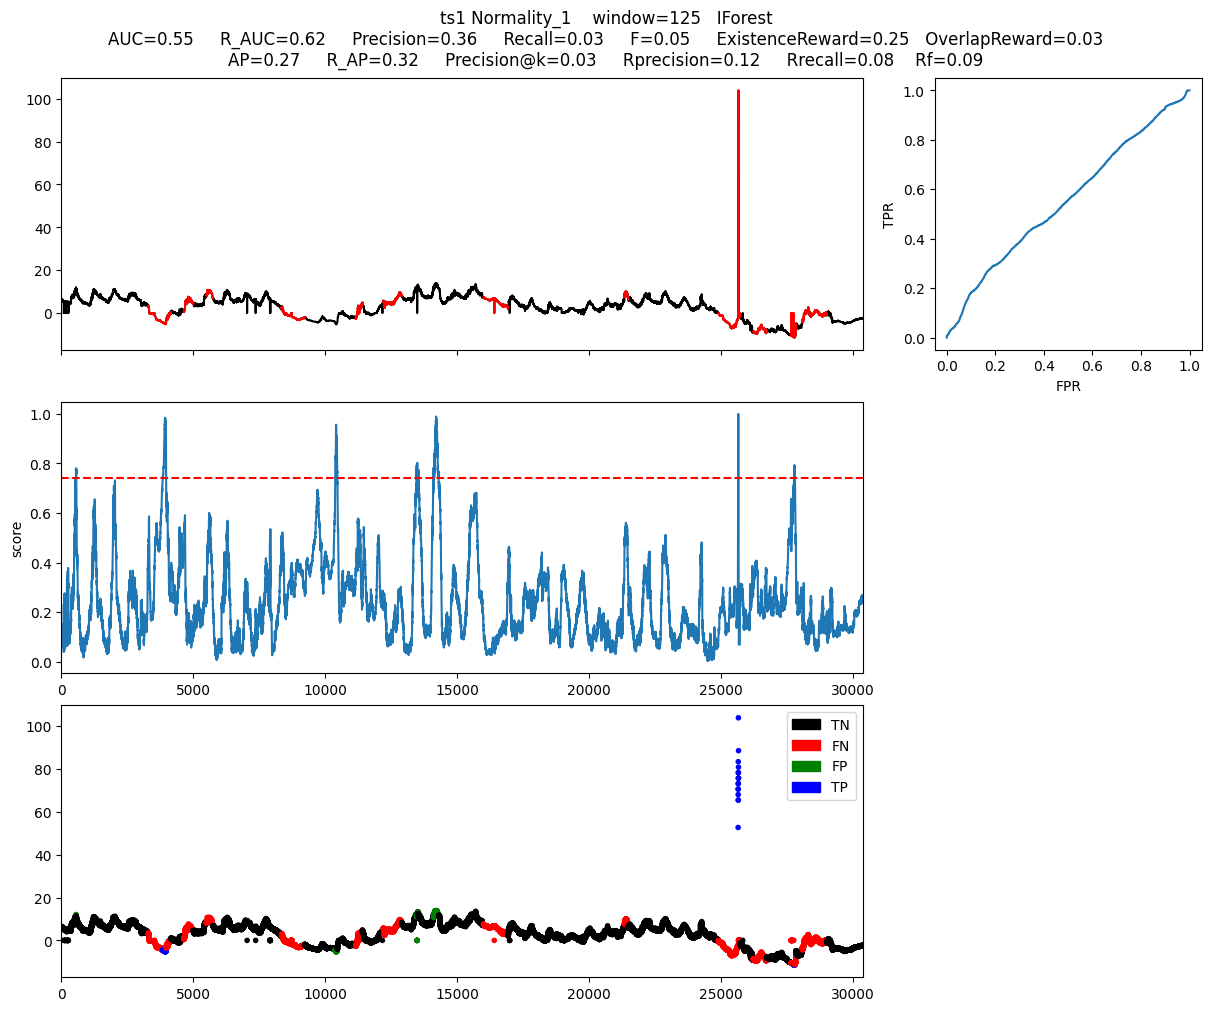

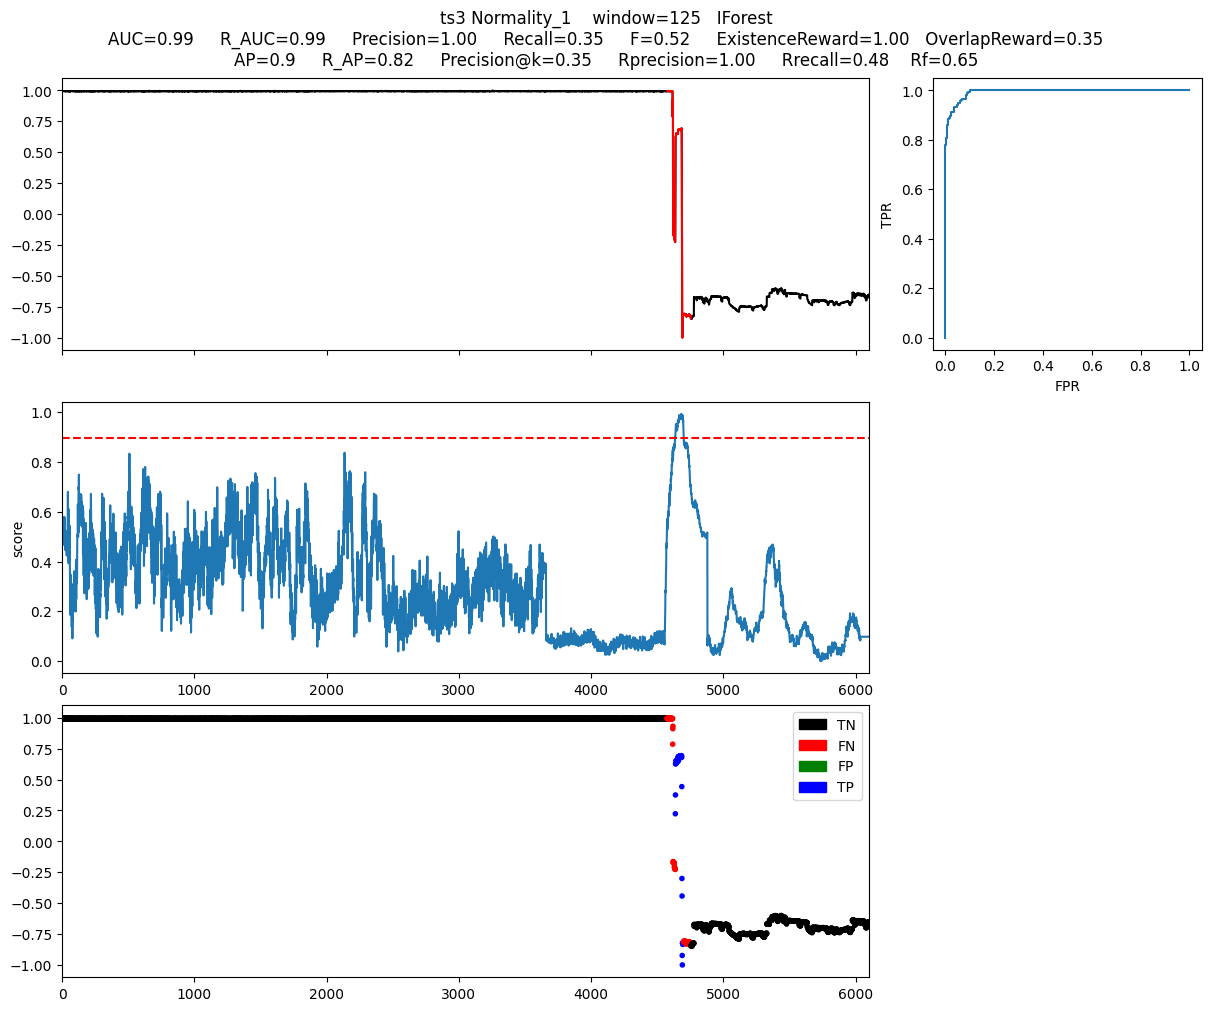

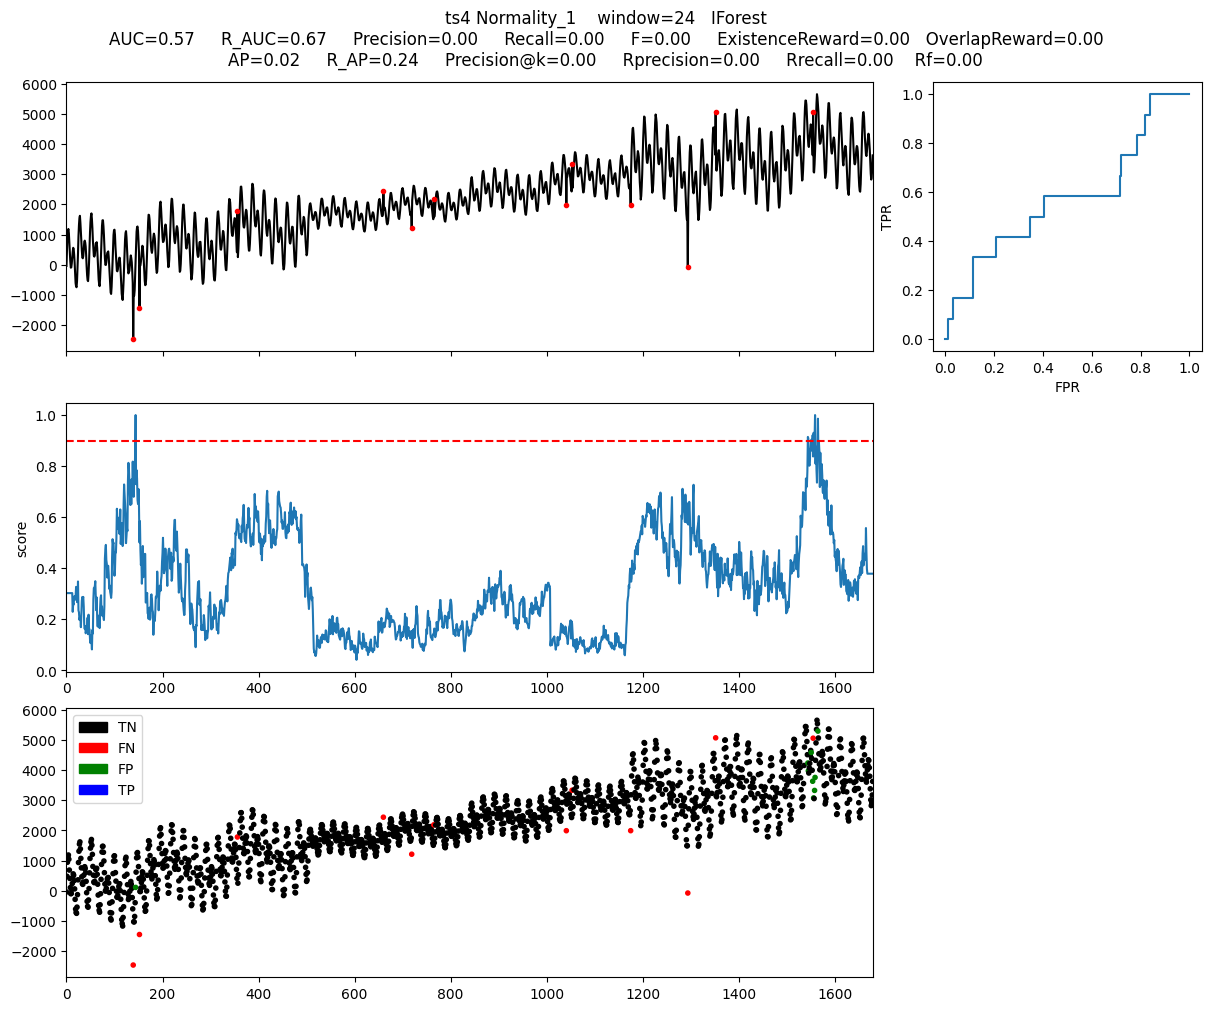

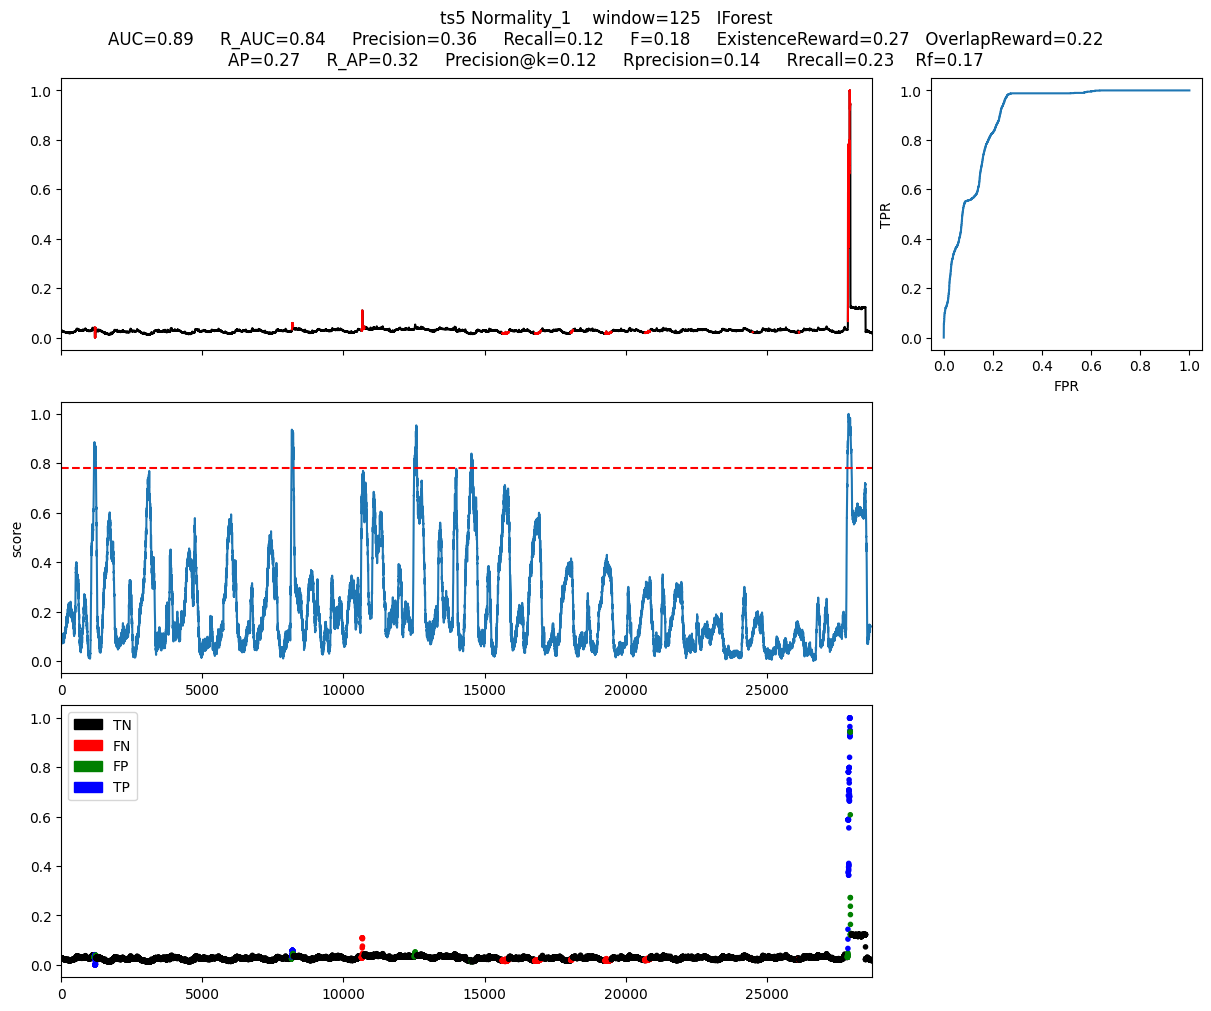

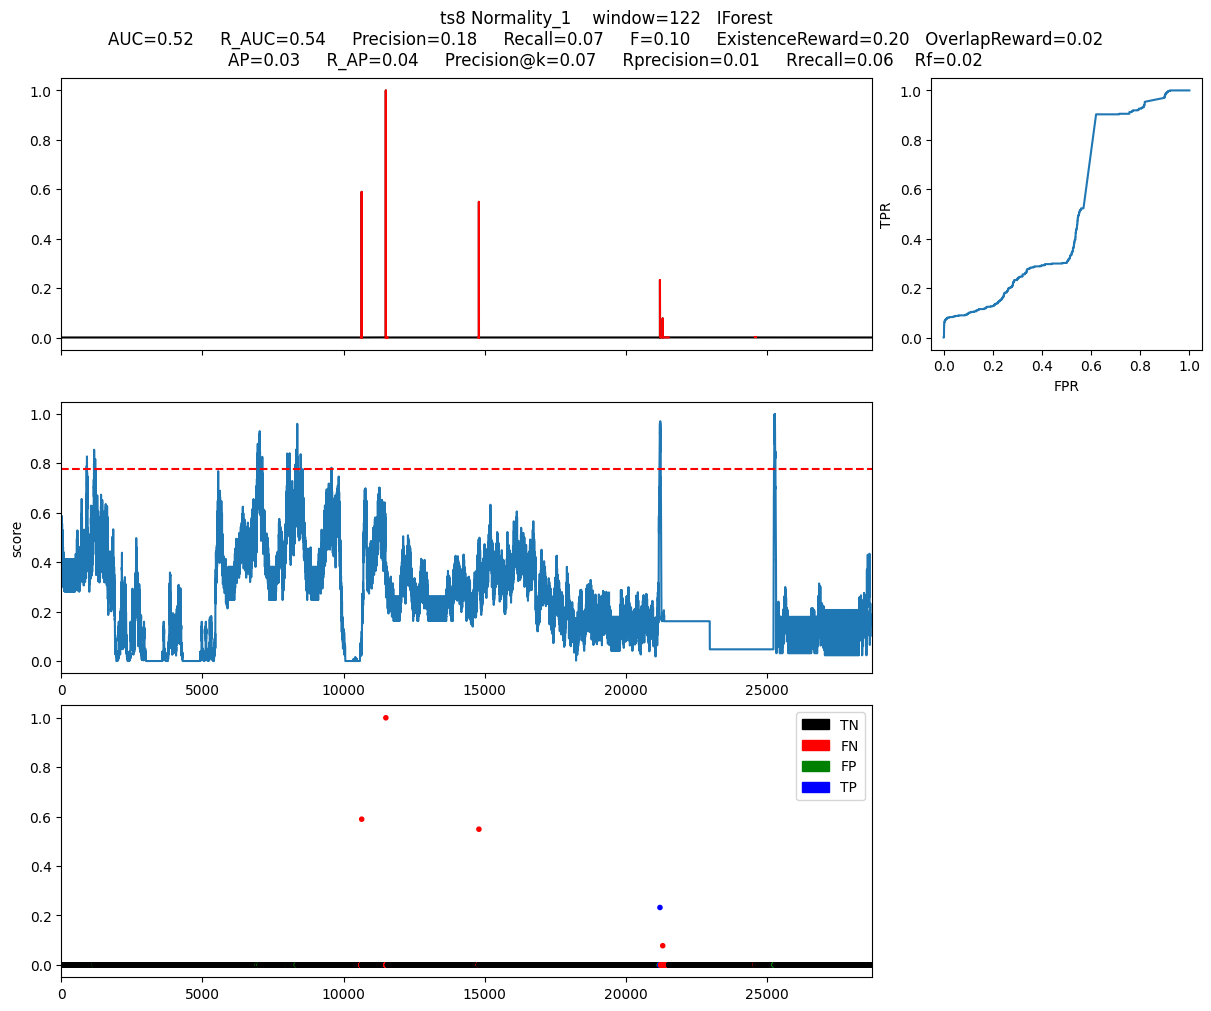

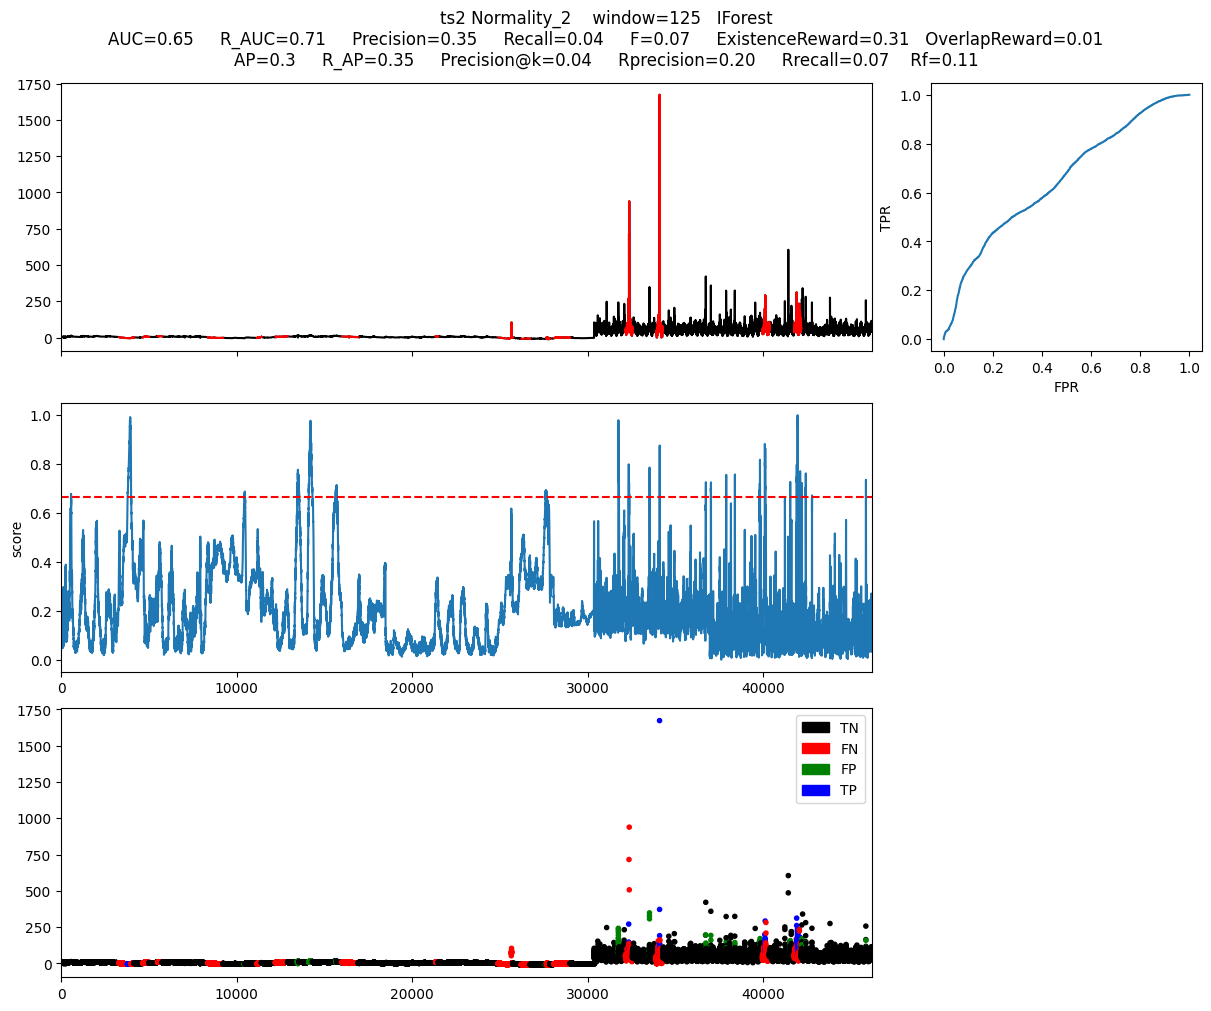

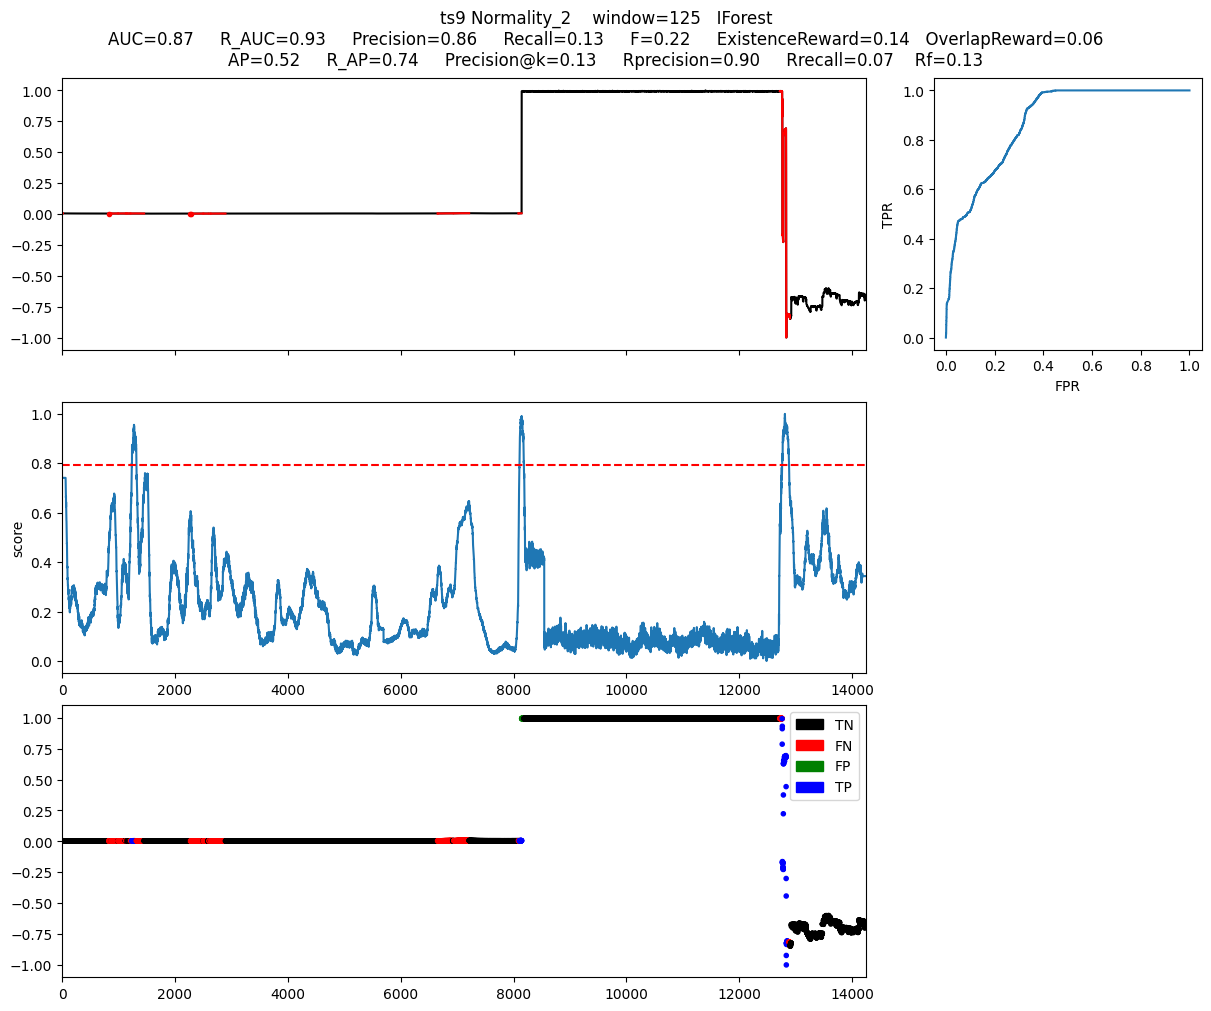

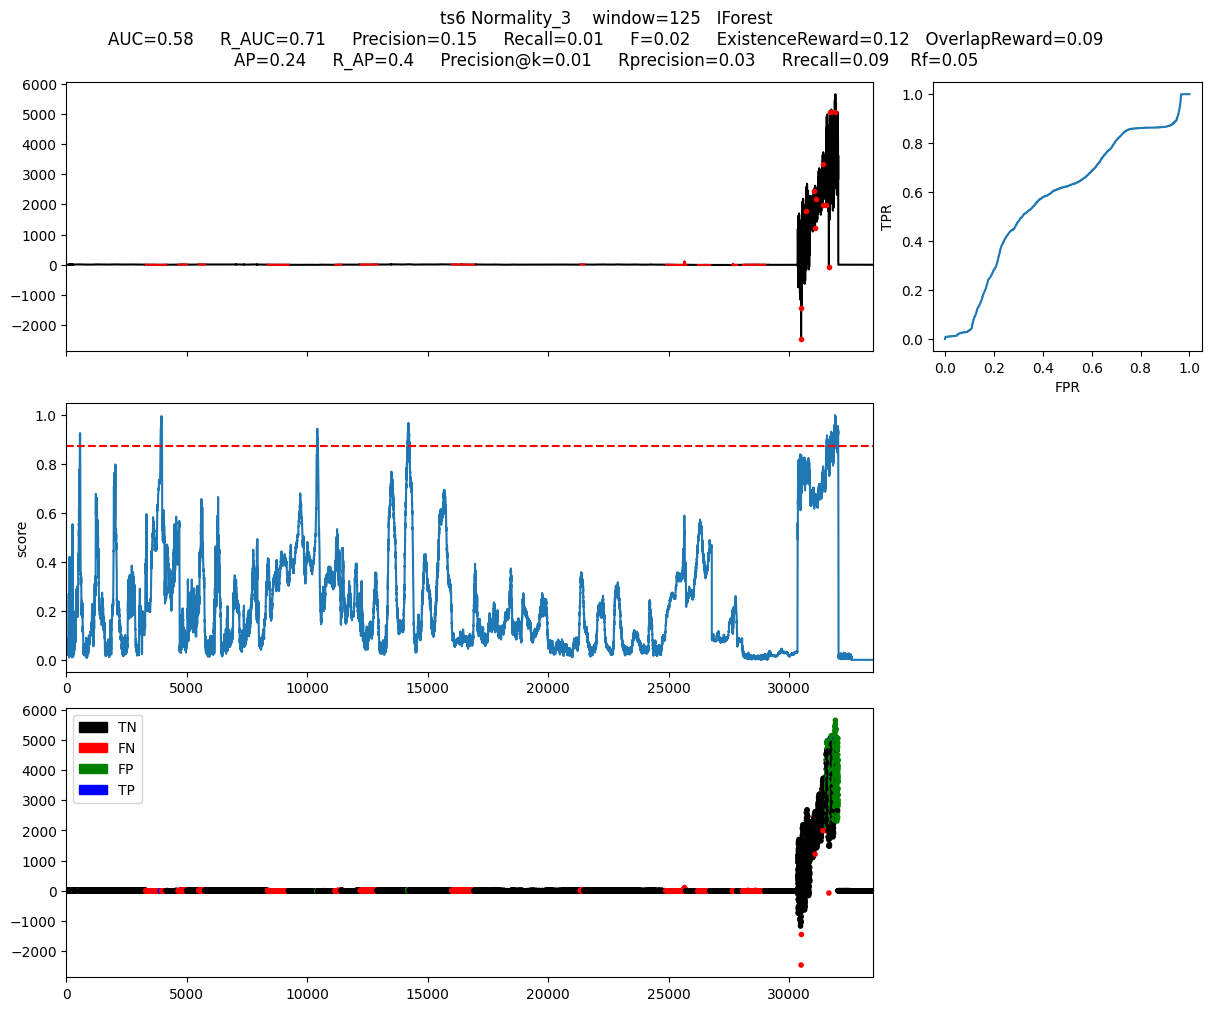

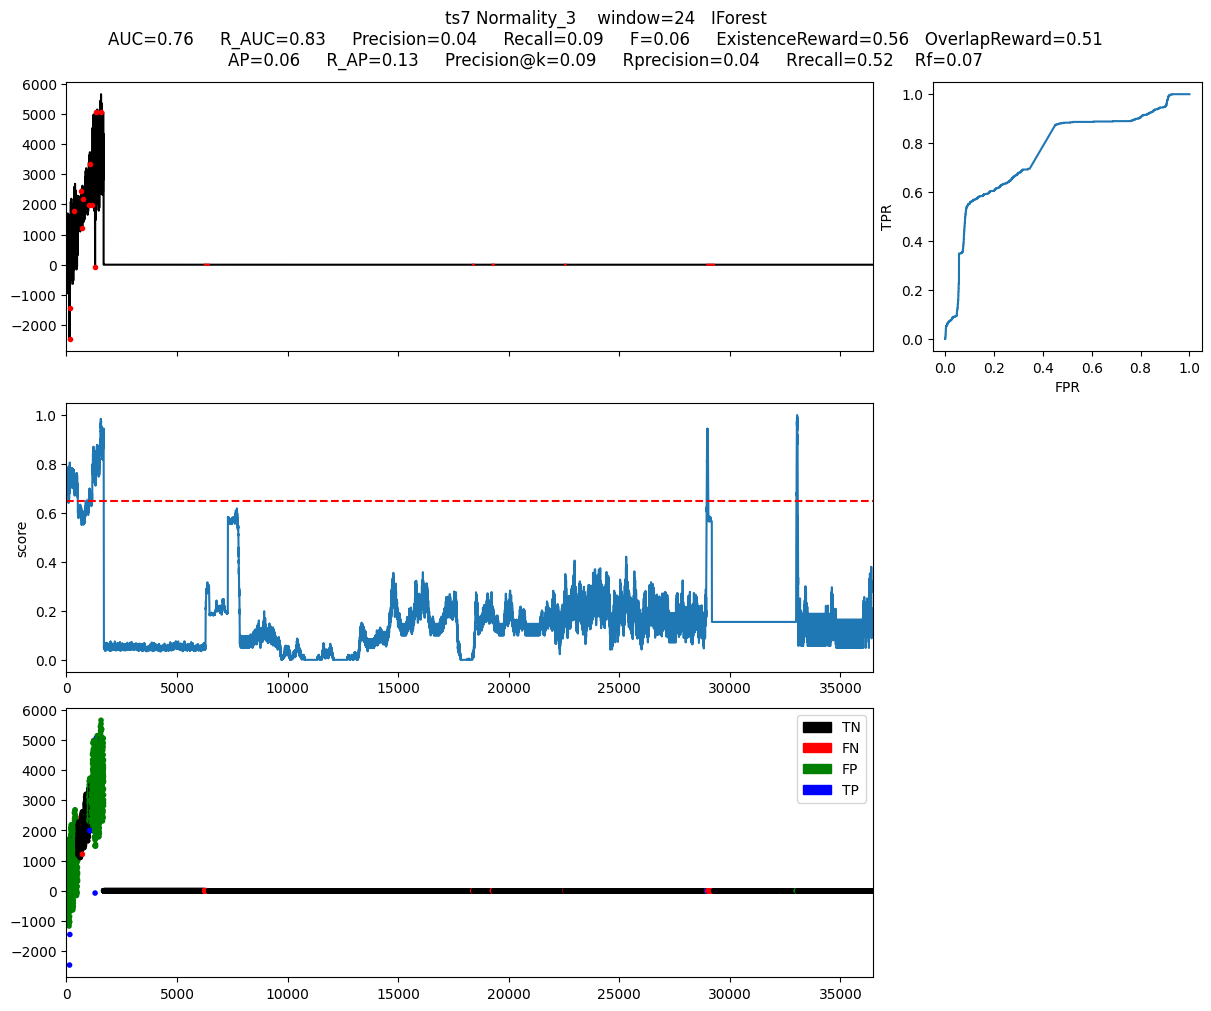

In [30]:
results = []

for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]
    scores = []
    previous_scores = None
    

    for par in range(n):

        clf = IForest(n_jobs=1, random_state=42)
        
        if par == 0:
            partition = ts['data partitions'][par]
            slidingWindow = find_length(partition)
            X_train = Window(window=slidingWindow).convert(partition).to_numpy()
        else:
            partition_with_history = np.concatenate((ts['data partitions'][par-1], ts['data partitions'][par]))
            slidingWindow = find_length(partition_with_history)
            X_train = Window(window=slidingWindow).convert(partition_with_history).to_numpy()
        
        clf.fit(X_train)
        score = clf.decision_scores_

        score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
        score = np.array([score[0]] * math.ceil((slidingWindow-1)/2) +
                         list(score) +
                         [score[-1]] * ((slidingWindow-1)//2))

        if par > 0:
            previous_partition_length = len(ts['data partitions'][par-1])
            new_previous_scores = score[:previous_partition_length]
            mean_previous_scores = (previous_scores + new_previous_scores) / 2
            scores[-previous_partition_length:] = mean_previous_scores.tolist()

        current_partition_length = len(ts['data partitions'][par])
        current_scores = score[-current_partition_length:]
        scores.extend(current_scores)

        previous_scores = current_scores
    
    scores = np.array(scores)
    # Plot figure
    plotFig(ts['data'], ts['label'], scores, ts['global_sliding_window'], fileName=ts['name'] + ' ' + loaded_dict[ts['name']][0], modelName=modelName)

    # Calculate the results
    L = printResult(ts['data'], ts['label'], scores, ts['global_sliding_window'], ts['name'], modelName)
    L = [ '%.2f' % elem for elem in L]
    results.append([filename] + L)

In [31]:
columns = ['Filename'] + eval_metrics
iforest_res = pd.DataFrame(results, columns=columns)

In [32]:
iforest_res

Filename   AUC Precision Recall     F Rrecall ExistenceReward OverlapReward  \
0      ts1  0.55      0.36   0.03  0.05    0.08            0.25          0.03   
1      ts3  0.99      1.00   0.35  0.52    0.48            1.00          0.35   
2      ts4  0.57      0.00   0.00  0.00    0.00            0.00          0.00   
3      ts5  0.89      0.36   0.12  0.18    0.23            0.27          0.22   
4      ts8  0.52      0.18   0.07  0.10    0.06            0.20          0.02   
5      ts2  0.65      0.35   0.04  0.07    0.07            0.31          0.01   
6      ts9  0.87      0.86   0.13  0.22    0.07            0.14          0.06   
7      ts6  0.58      0.15   0.01  0.02    0.09            0.12          0.09   
8      ts7  0.76      0.04   0.09  0.06    0.52            0.56          0.51   

  Rprecision    Rf Precision@k R_AUC  
0       0.12  0.09        0.03  0.62  
1       1.00  0.65        0.35  0.99  
2       0.00  0.00        0.00  0.67  
3       0.14  0.17        0.12  0.84  
4       0.01  0.02        0.07  0.54  
5       0.20  0.11        0.04  0.71  
6       0.90  0.13        0.13  0.93  
7       0.03  0.05        0.01  0.71  
8       0.04  0.07        0.09  0.83

In [33]:
iforest_res.to_csv('Results/Isolation-Forest/IForest_Streaming_Batch_History_Variant.csv', index=False)

In [34]:
iforest_orig_res = pd.read_csv('Results/Isolation-Forest/IForest_Non-Streaming.csv')
iforest_stream_var1_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Naive_Variant.csv')
iforest_stream_var2_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Batch_History_Variant.csv')

filenames_col = iforest_orig_res.iloc[:,0]

iforest_orig_res = iforest_orig_res.iloc[:, 1:]
iforest_stream_var1_res = iforest_stream_var1_res.iloc[:, 1:]
iforest_stream_var2_res = iforest_stream_var2_res.iloc[:, 1:]

In [35]:
res_diff =  iforest_stream_var2_res - iforest_stream_var1_res

res_diff.insert(0, 'Filename', filenames_col)

res_diff = res_diff.style.applymap(highlight_diff, subset=pd.IndexSlice[:, res_diff.columns[1:]])

res_diff

### ***Isolation Forest***(Variant 3)
Dynamic partitioning and classification based on ensemblers

In [94]:
modelName = 'IForest'
clf = IForest(n_jobs=1, random_state=42)


Evaluates the last p points of the previous partition with both classifiers and replaces scores if they disagree.

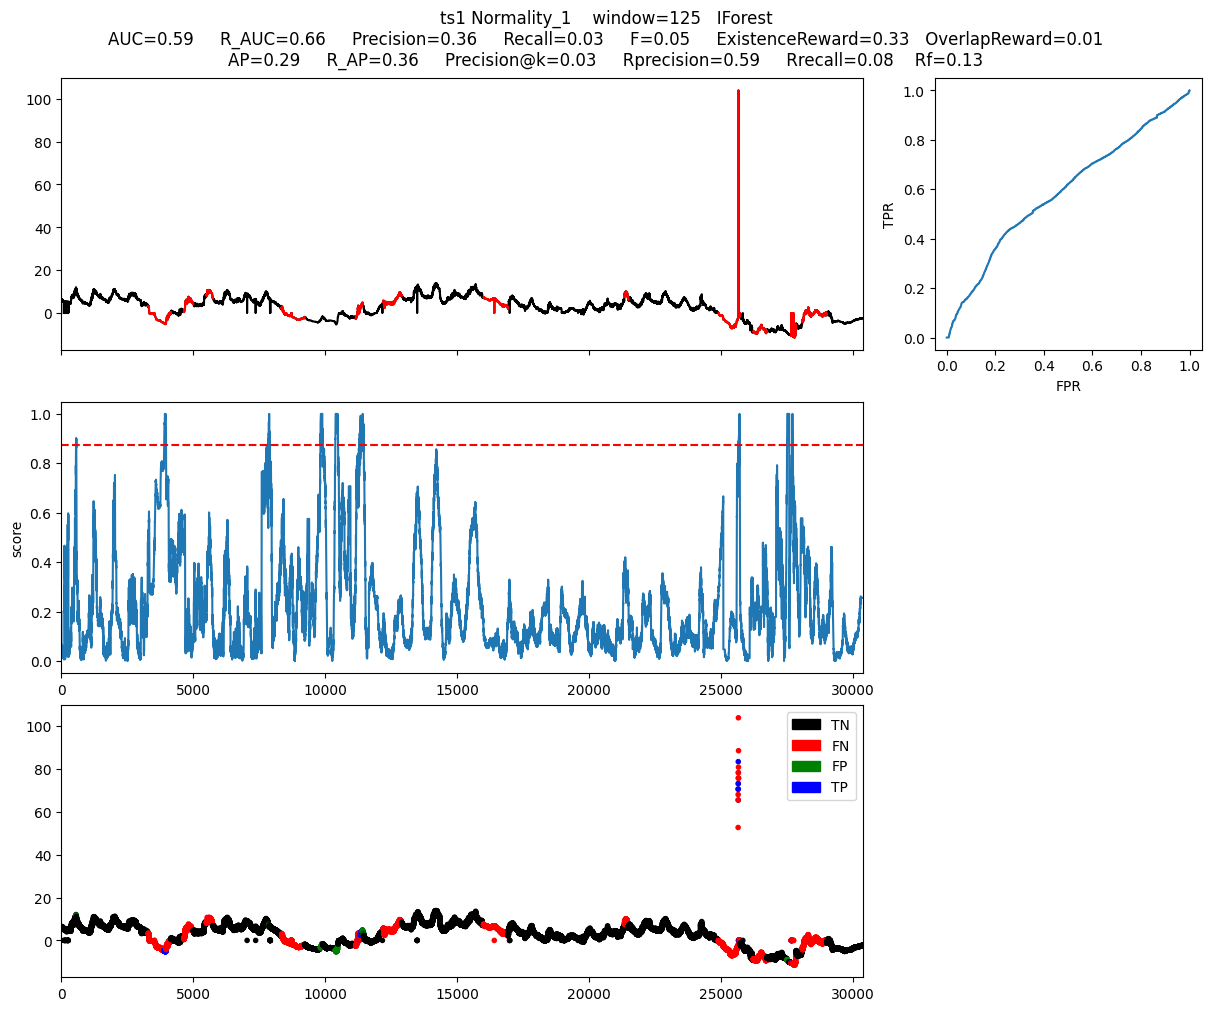

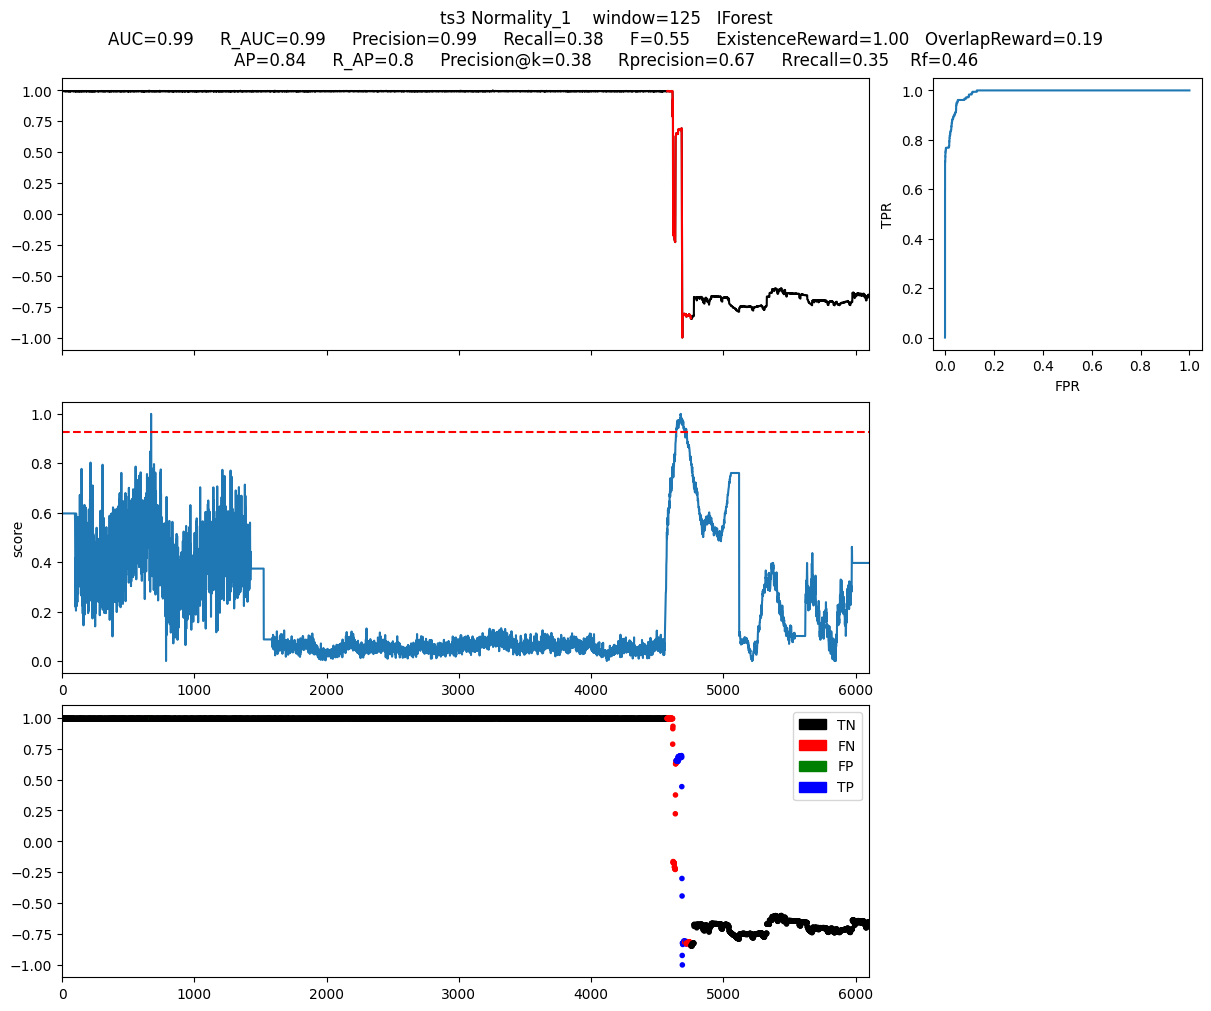

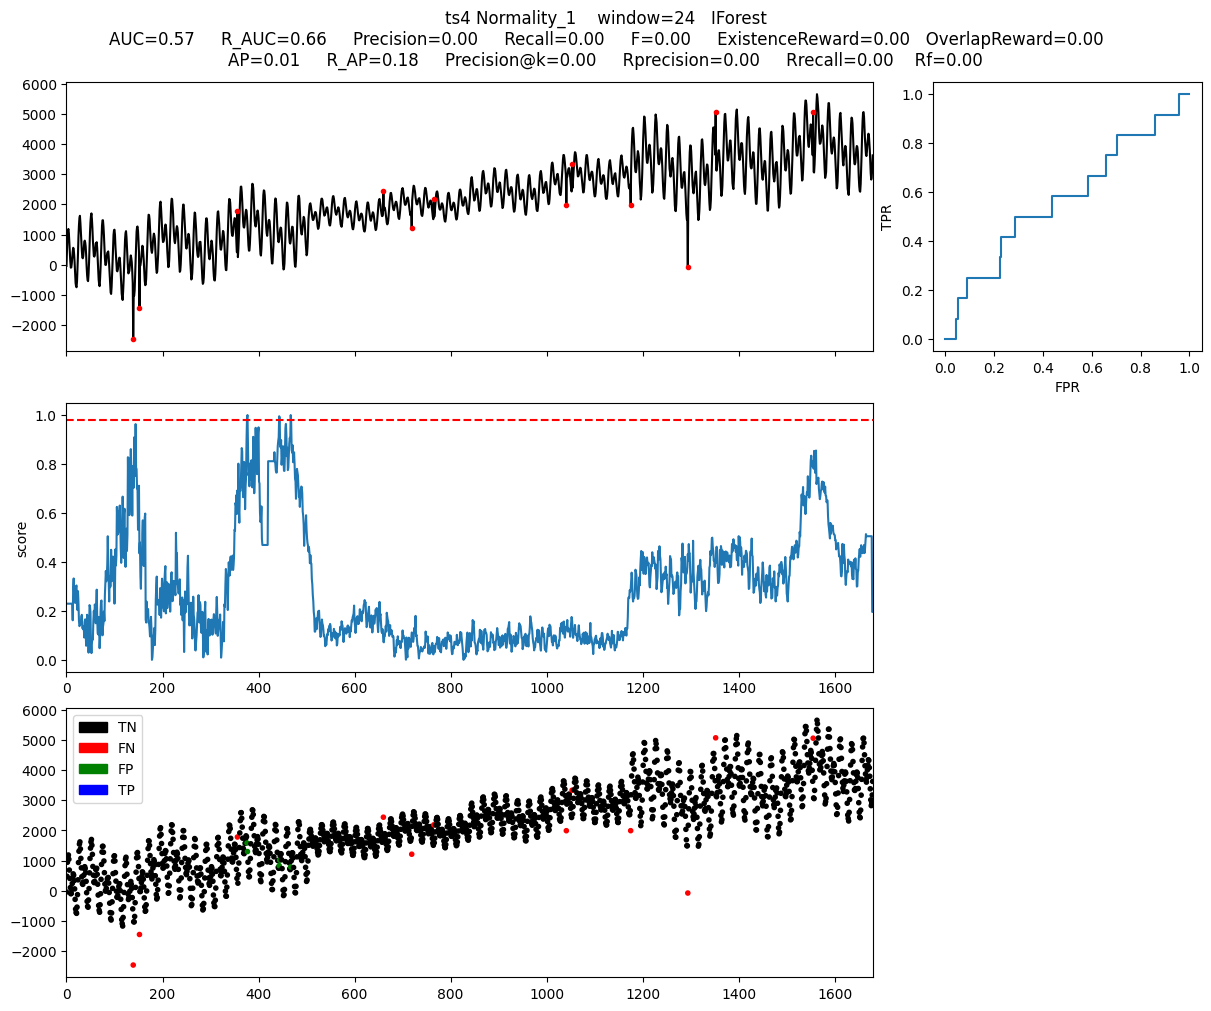

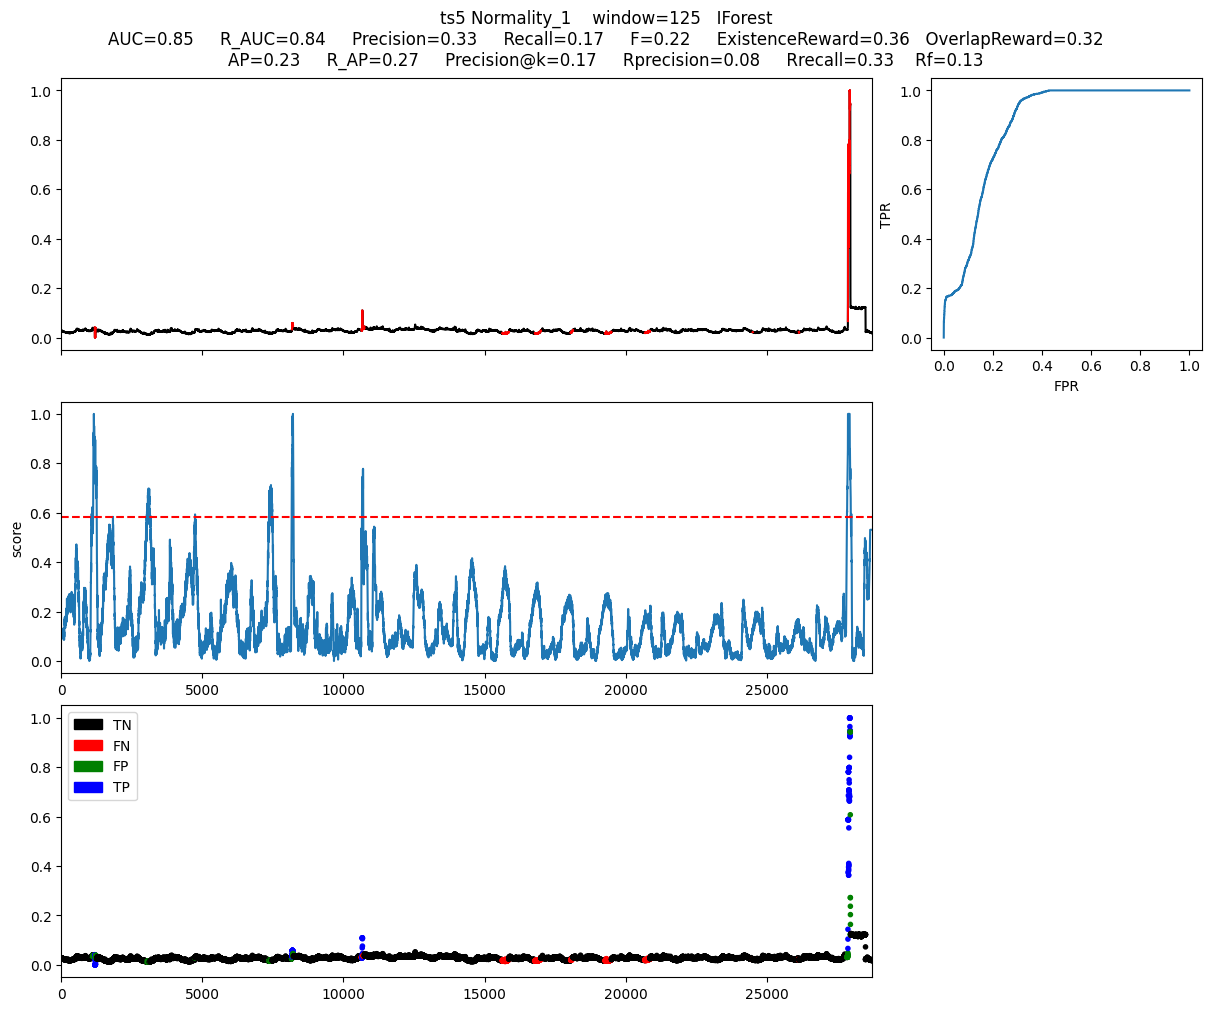

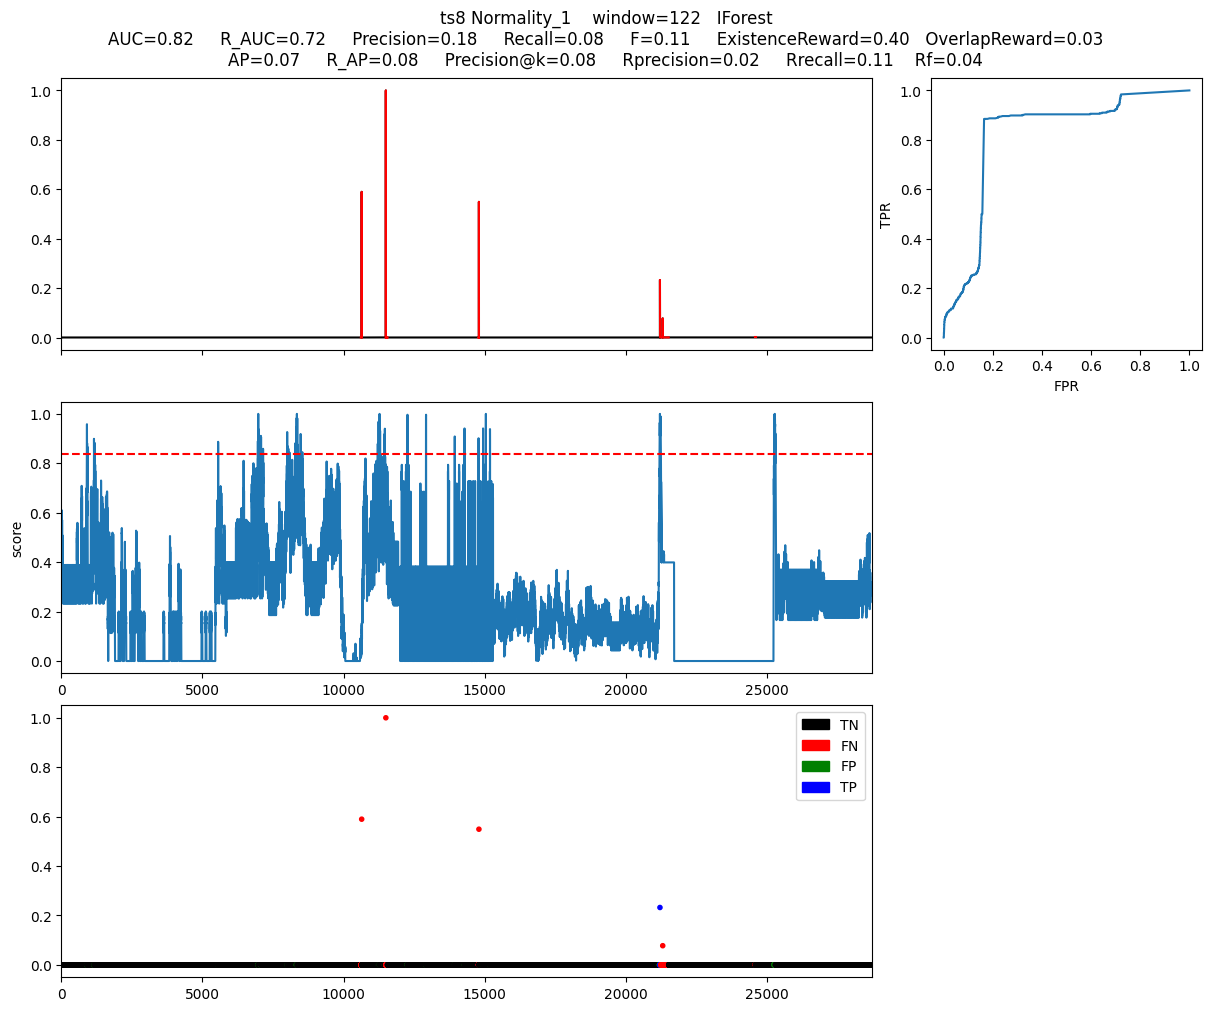

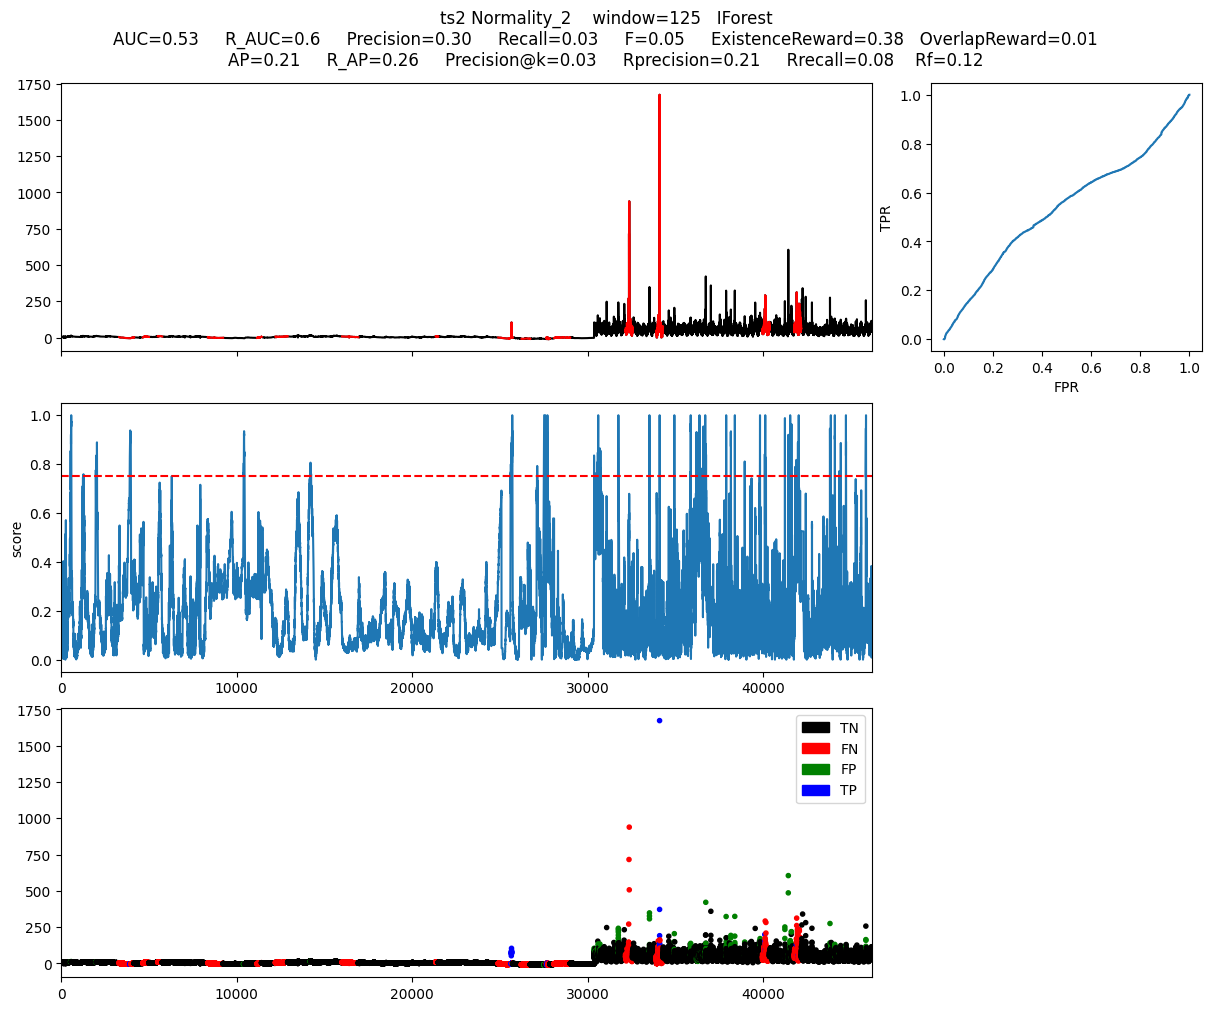

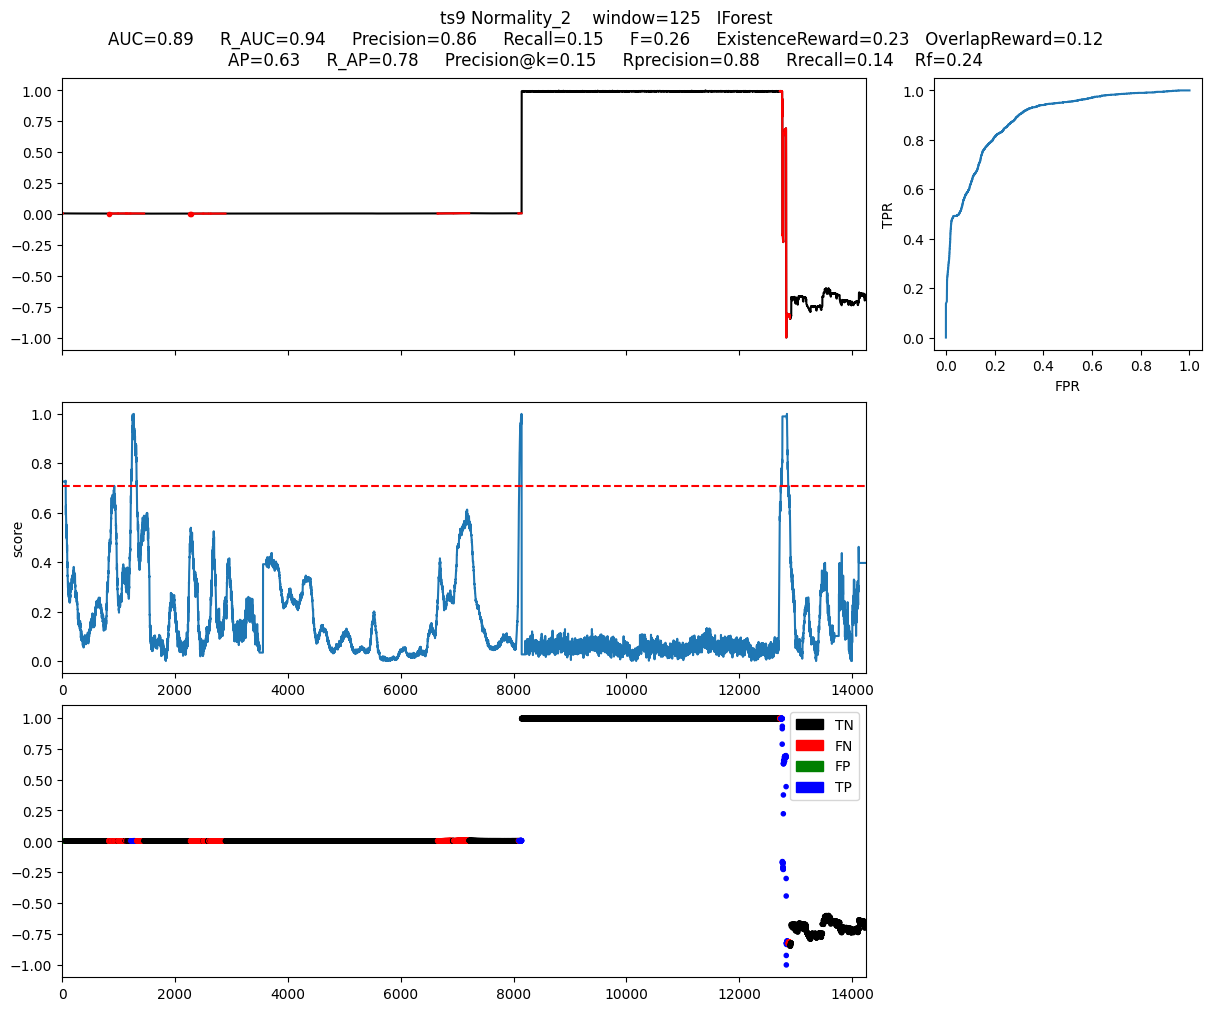

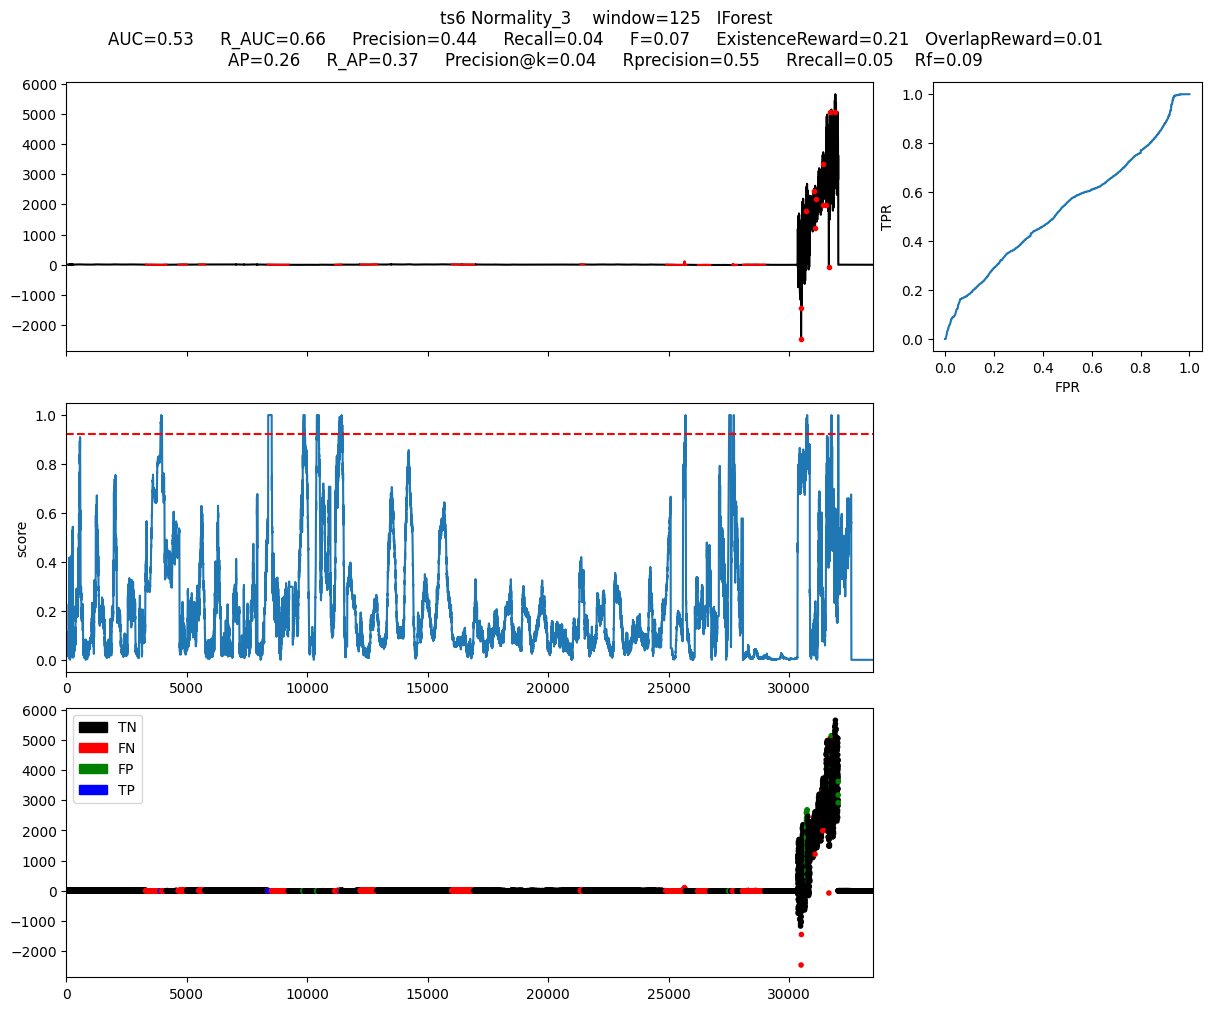

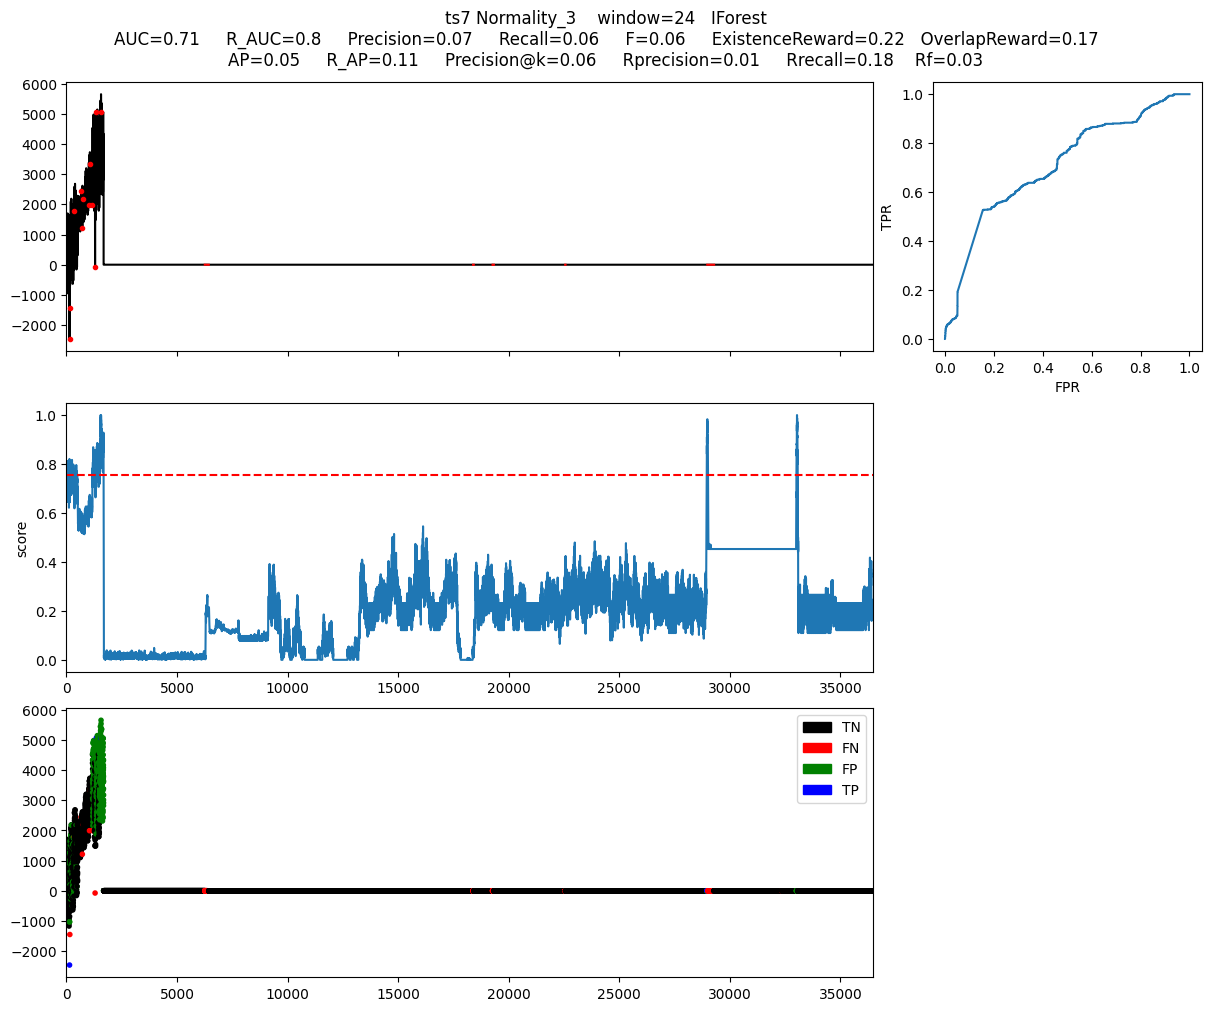

In [95]:
results = []
disagreement_threshold = 0.5

for filename in preprocessed_dict.keys():
    ts = preprocessed_dict[filename]
    scores = []
    previous_scores = None

    for par in range(len(ts['data partitions'])):

        if par == 0 or par == 1:
            partition = ts['data partitions'][par]
            slidingWindow = find_length(partition)
            X_train = Window(window=slidingWindow).convert(partition).to_numpy()
        else:
            previous_partition = ts['data partitions'][par-1]
            partition = ts['data partitions'][par]
            last_p_points = previous_partition[-p:]
            partition_with_history = np.concatenate((last_p_points, partition))
            slidingWindow = find_length(partition_with_history)
            X_train = Window(window=slidingWindow).convert(partition_with_history).to_numpy()
        
        clf.fit(X_train)
        score = clf.decision_scores_

        score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
        score = np.array([score[0]] * math.ceil((slidingWindow-1)/2) +
                        list(score) +
                        [score[-1]] * ((slidingWindow-1)//2))
        
        if par > 1:
            previous_partition_length = len(previous_partition)
            new_previous_scores = score[:p]
            prev_scores_to_compare = previous_scores[-p:]
            
            disagreement_indices = np.where(np.abs(prev_scores_to_compare - new_previous_scores) > disagreement_threshold)[0]
            if len(disagreement_indices) > p * 0.5:
                previous_scores[-p:] = new_previous_scores
            
            scores[-p:] = previous_scores[-p:]
            current_scores = score[p:]
        else:
            current_scores = score

        scores.extend(current_scores)
        previous_scores = current_scores

    scores = np.array(scores)
    # Plot figure
    plotFig(ts['data'], ts['label'], scores, ts['global_sliding_window'], fileName=ts['name'] + ' ' + loaded_dict[ts['name']][0], modelName=modelName)

    # Calculate the results
    L = printResult(ts['data'], ts['label'], scores, ts['global_sliding_window'], ts['name'], modelName)
    L = [ '%.2f' % elem for elem in L]
    results.append([filename] + L)

In [96]:
columns = ['Filename'] + eval_metrics
iforest_res = pd.DataFrame(results, columns=columns)

In [97]:
iforest_res

Filename   AUC Precision Recall     F Rrecall ExistenceReward OverlapReward  \
0      ts1  0.59      0.36   0.03  0.05    0.08            0.33          0.01   
1      ts3  0.99      0.99   0.38  0.55    0.35            1.00          0.19   
2      ts4  0.57      0.00   0.00  0.00    0.00            0.00          0.00   
3      ts5  0.85      0.33   0.17  0.22    0.33            0.36          0.32   
4      ts8  0.82      0.18   0.08  0.11    0.11            0.40          0.03   
5      ts2  0.53      0.30   0.03  0.05    0.08            0.38          0.01   
6      ts9  0.89      0.86   0.15  0.26    0.14            0.23          0.12   
7      ts6  0.53      0.44   0.04  0.07    0.05            0.21          0.01   
8      ts7  0.71      0.07   0.06  0.06    0.18            0.22          0.17   

  Rprecision    Rf Precision@k R_AUC  
0       0.59  0.13        0.03  0.66  
1       0.67  0.46        0.38  0.99  
2       0.00  0.00        0.00  0.66  
3       0.08  0.13        0.17  0.84  
4       0.02  0.04        0.08  0.72  
5       0.21  0.12        0.03  0.60  
6       0.88  0.24        0.15  0.94  
7       0.55  0.09        0.04  0.66  
8       0.01  0.03        0.06  0.80

In [98]:
iforest_res.to_csv('Results/Isolation-Forest/IForest_Streaming_Dynamic_Partitioning_Variant.csv', index=False)

In [99]:
iforest_orig_res = pd.read_csv('Results/Isolation-Forest/IForest_Non-Streaming.csv')
iforest_stream_var1_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Naive_Variant.csv')
iforest_stream_var2_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Batch_History_Variant.csv')
iforest_stream_var3_res = pd.read_csv('Results/Isolation-Forest/IForest_Streaming_Dynamic_Partitioning_Variant.csv')


filenames_col = iforest_orig_res.iloc[:,0]

iforest_orig_res = iforest_orig_res.iloc[:, 1:]
iforest_stream_var1_res = iforest_stream_var1_res.iloc[:, 1:]
iforest_stream_var2_res = iforest_stream_var2_res.iloc[:, 1:]
iforest_stream_var3_res = iforest_stream_var3_res.iloc[:, 1:]

In [100]:
res_diff =  iforest_stream_var3_res - iforest_stream_var2_res

res_diff.insert(0, 'Filename', filenames_col)

res_diff = res_diff.style.applymap(highlight_diff, subset=pd.IndexSlice[:, res_diff.columns[1:]])

res_diff